# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
#!pip install opencv-python

In [2]:
# !pip install tensorflow

In [3]:
#!pip install keras

In [1]:
# import required libraries
import numpy as np

# from scipy.misc import imread, imresize
import datetime
import os
from skimage import io
import imageio
import skimage
import random
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
# tf.random.set_seed(30)
# 
tf.set_random_seed(30)

Using TensorFlow backend.


In [2]:
# import libraries from the keras
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.regularizers import l2
from keras.layers.recurrent import LSTM
from keras.layers.normalization import BatchNormalization

In [3]:
# function to plot history for loss asn accuracy two subplots
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    print(history.history.keys())  


    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

In [4]:
# funtion to plot the the history: accuracy and loss
def plot2(history):
    # list all data in history
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [5]:
# read the csv file for train and validation
# train_doc = np.random.permutation(open('./train.csv').readlines())
# val_doc = np.random.permutation(open('./val.csv').readlines())
train_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val.csv').readlines())


# Experiment No. 1a
# with resize only, no cropping

# Experiment Test without  cropping the image with resize and normalize
# image size (120,120)
#Default learning rate for optimizer

In [15]:
# generator function with resize  and normalize

def generator_nocrop(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    

                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                   
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [14]:
# Parameters initialization

x = 30   # no. of frames to be considered
y = 120  # width y dimesnion of the image
z = 120  # height z of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray
batch_size = 20 # experiment with the batch size
num_epochs = 10 # choose the number of epochs

In [16]:
# curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

print ('# epochs =', num_epochs)
print('# experiment with the batch size= ', batch_size )

# training sequences = 663
# validation sequences = 100
# epochs = 10
 # experiment with the batch size=  20


In [18]:
# Create the model

no_classes = 5
crop_model = Sequential()
crop_model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30,120,120,3)))
crop_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
crop_model.add(Dropout(0.5))
crop_model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
crop_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
crop_model.add(Dropout(0.5))
crop_model.add(Flatten())
crop_model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
crop_model.add(Dense(no_classes, activation='softmax'))


optimiser = optimizers.Adam() #write your optimizer
crop_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (crop_model.summary())

train_generator = generator_nocrop(train_path, train_doc, batch_size)
val_generator= generator_nocrop(val_path, val_doc, batch_size)

curr_dt_time = datetime.datetime.now()
model_name = 'modelcrop_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   

In [19]:
history_crop = crop_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 1117s 33s/step - loss: 12.4393 - categorical_accuracy: 0.2082 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to modelcrop_init_2020-06-3015_17_02.862177/model-00001-12.48142-0.20513-12.73330-0.21000.h5
Epoch 2/10
34/34 [==============================] - 280s 8s/step - loss: 13.2737 - categorical_accuracy: 0.1765 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to modelcrop_init_2020-06-3015_17_02.862177/model-00002-13.27373-0.17647-12.73330-0.21000.h5
Epoch 3/10
34/34 [==============================] - 280s 8s/step - loss: 12.7997 - categorical_accuracy: 0.2059 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to

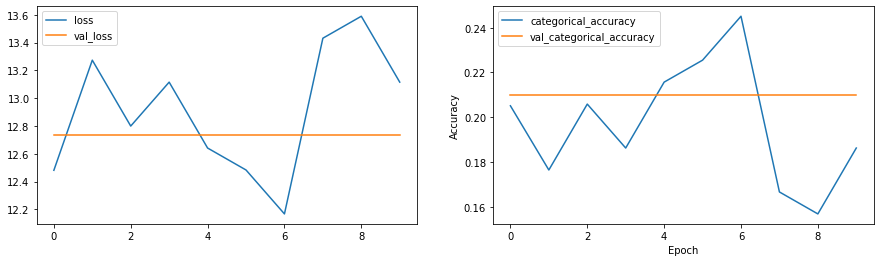

In [24]:
plot(history_crop)

# Experiment No. 1b 
# without crop and resize
# Throws error

In [20]:
def generator_nocropresize(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                
                    # resize
                    
                  
                    
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                    #print(t_image.shape)
                    
                 
                    #print(t_image[0].shape)
                    #print(t_image[1].shape)
                    #print(t_image[2].shape)
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                
                    # resize
                    
                    
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [21]:
no_classes = 5
cropresize_model = Sequential()
cropresize_model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30,120,120,3)))
cropresize_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
cropresize_model.add(Dropout(0.5))
cropresize_model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
cropresize_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
cropresize_model.add(Dropout(0.5))
cropresize_model.add(Flatten())
cropresize_model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
cropresize_model.add(Dense(no_classes, activation='softmax'))


optimiser = optimizers.Adam() #write your optimizer
cropresize_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cropresize_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 28, 118, 118, 32)  2624      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 14, 59, 59, 32)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 59, 59, 32)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 12, 57, 57, 64)    55360     
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 6, 28, 28, 64)     0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 28, 28, 64)     0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 301056)            0         
__________

In [22]:
train_generator = generator_nocropresize(train_path, train_doc, batch_size)
val_generator= generator_nocropresize(val_path, val_doc, batch_size)

curr_dt_time = datetime.datetime.now()
model_name = 'modelcropresize_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   

In [23]:
history_cropresize = cropresize_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20


ValueError: could not broadcast input array from shape (120,160) into shape (120,120)

# Experiment 1c with resize and crop
# with less train sequences (reduced 1/3rd)
# with Conv3D
#  Adam optimizer : learning rate = .001

In [9]:
# Parameters initialization

x = 30   # no. of frames of the image
y = 120  # width y dimesnion of the image
z = 120  # height z of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray
batch_size = 20 # experiment with the batch size
num_epochs = 20

In [10]:
def generator_overf(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # This is because cv2 read images in (b,g,r)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:140] #cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) #skimage.transform.resize(image,(120,120))  
                    else:
                        image
                      
                       
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                    #print(t_image.shape)
                    

                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:140] #cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) #skimage.transform.resize(image,(120,120))  
                    else:
                        image
                        
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                   
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [11]:
# curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
print ('# Batch size =', batch_size)
num_train_sequences_red = num_train_sequences//3
print('# training sequences_reduced =', num_train_sequences_red)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# Batch size = 20
# training sequences_reduced = 221


In [12]:
no_classes = 5

model_lesstrain = Sequential()
model_lesstrain.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(x,120,120,3)))
model_lesstrain.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_lesstrain.add(Dropout(0.5))
model_lesstrain.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model_lesstrain.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_lesstrain.add(Dropout(0.5))
model_lesstrain.add(Flatten())
model_lesstrain.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model_lesstrain.add(Dense(no_classes, activation='softmax'))

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_lesstrain.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_lesstrain.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 28, 118, 118, 32)  2624      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 14, 59, 59, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 59, 59, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 57, 57, 64)    55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 6, 28, 28, 64)     0         
_________________________________________________________________
dropout_2 (Dropout)  

In [13]:
train_generator = generator_overf(train_path, train_doc, batch_size)
val_generator = generator_overf(val_path, val_doc, batch_size)

curr_dt_time = datetime.datetime.now()
model_name = 'model_lesstrain_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# reduce to 1/3 rd
num_train_sequences = num_train_sequences//3

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   

In [14]:
history_model_lesstrain = model_lesstrain.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size =Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
 20
12/12 [==============================] - 413s 34s/step - loss: 12.5231 - categorical_accuracy: 0.1667 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_lesstrain_init_2020-06-2918_37_07.302730/model-00001-12.52308-0.16667-13.53920-0.16000.h5
Epoch 2/20
12/12 [==============================] - 408s 34s/step - loss: 12.9616 - categorical_accuracy: 0.1958 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_lesstrain_init_2020-06-2918_37_07.302730/model-00002-12.96163-0.19583-13.53920-0.16000.h5
Epoch 3/20
12/12 [==============================] - 335s 28s/step - loss: 13.9244 - categorical_accuracy: 0.1361 - val_loss: 13.5392 - v

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


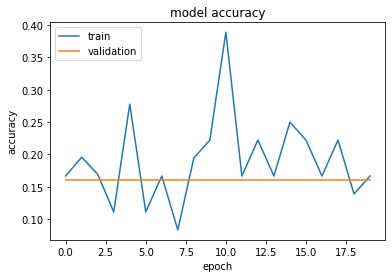

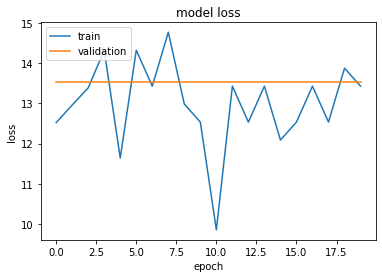

In [15]:
plot(history_model_lesstrain)


# Experiment 2 a
# batch size =100, num_epochs=20
#conv3d->MaxPooling3D->conv3d->MaxPooling3D->Flatten->Dense->Dense(softmax)

In [2]:
# train_doc = np.random.permutation(open('./train.csv').readlines())
# val_doc = np.random.permutation(open('./val.csv').readlines())
train_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val.csv').readlines())


In [3]:
# Parameters initialization
x = 30   # no. of images of the image
y = 120  # width y dimesnion of the image
z = 120  # height z of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) 
batch_size = 100 # experiment with the batch size

In [26]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:140] 
                    else:
                        image

                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                   
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:120] 
                    else:
                        image
                       
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [4]:
# curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [48]:
# Create the model
# Overfitting model
no_classes = 5
model_0 = Sequential()
model_0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30,120,120,3)))
model_0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_0.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model_0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_0.add(Flatten())
model_0.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model_0.add(Dense(no_classes, activation='softmax'))

In [49]:
optimiser_0 = optimizers.Adam(lr=0.001) #write your optimizer
model_0.compile(optimizer=optimiser_0, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_0.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 28, 118, 118, 32)  2624      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 14, 59, 59, 32)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 12, 57, 57, 64)    55360     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 6, 28, 28, 64)     0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 301056)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               77070592  
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 1285      
Total para

In [50]:
train_generator_0 = generator(train_path, train_doc, batch_size)
val_generator_0 = generator(val_path, val_doc, batch_size)

In [51]:
curr_dt_time = datetime.datetime.now()
model_name0 = 'model0_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name0):
    os.mkdir(model_name0)
        
filepath = model_name0 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR0 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR0]

In [52]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [53]:
history_0 = model_0.fit_generator(train_generator_0, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_0, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 100
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 100
7/7 [==============================] - 1031s 147s/step - loss: 11.3012 - categorical_accuracy: 0.2016 - val_loss: 12.4109 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model0_init_2020-06-2719_50_34.095228/model-00001-11.21648-0.20211-12.41093-0.23000.h5
Epoch 2/20
7/7 [==============================] - 673s 96s/step - loss: 12.4997 - categorical_accuracy: 0.2245 - val_loss: 12.4109 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model0_init_2020-06-2719_50_34.095228/model-00002-12.49975-0.22449-12.41093-0.23000.h5
Epoch 3/20
7/7 [==============================] - 499s 71s/step - loss: 12.5955 - categorical_accuracy: 0.2186 - val_loss: 12.4109 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model0

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


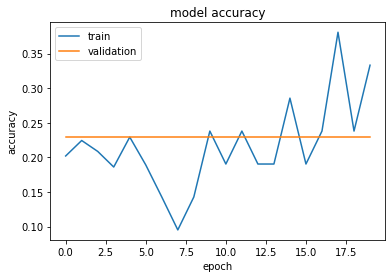

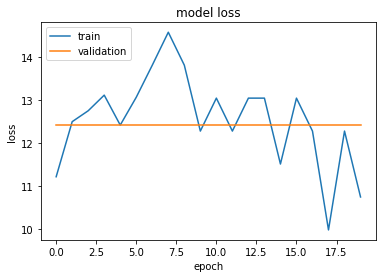

In [54]:
# list all data in history
plot(history_0)

# Experiment 2 b
# batch size= 100
# image =(120,120), lr= .001
# To avoid overfitting
#Adding Dropout to the model architecture allows us to ‘drop’ random elements from the feature maps during training. 
#Although this confuses the model, it disallows it to adapt too much to the training data
#conv3d->MaxPooling3D->Dropout->conv3d->MaxPooling3D->Dropout->Flatten->Dense->Dense(softmax)

In [55]:

# Create the model
model_02 = Sequential()
model_02.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30,120,120,3)))
model_02.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_02.add(Dropout(0.5))
model_02.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model_02.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_02.add(Dropout(0.5))
model_02.add(Flatten())
model_02.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model_02.add(Dense(no_classes, activation='softmax'))

optimiser_02 = optimizers.Adam(lr=0.001) #write your optimizer
model_02.compile(optimizer=optimiser_02, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_02.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 28, 118, 118, 32)  2624      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 14, 59, 59, 32)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 59, 59, 32)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 12, 57, 57, 64)    55360     
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 6, 28, 28, 64)     0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 6, 28, 28, 64)     0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 301056)            0         
__________

In [56]:
curr_dt_time = datetime.datetime.now()
model_name02 = 'model02_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name02):
    os.mkdir(model_name02)
        
filepath = model_name02 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR02 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR02]

In [57]:

# number of epochs =20, batch size = 100
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [58]:
history_02 = model_02.fit_generator(train_generator_0, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_0, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
7/7 [==============================] - 75s 11s/step - loss: 7.5093 - categorical_accuracy: 0.4286 - val_loss: 13.2168 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model02_init_2020-06-2721_02_14.451525/model-00001-7.50934-0.42857-13.21684-0.18000.h5
Epoch 2/20
7/7 [==============================] - 69s 10s/step - loss: 12.2805 - categorical_accuracy: 0.2381 - val_loss: 13.2168 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model02_init_2020-06-2721_02_14.451525/model-00002-12.28045-0.23810-13.21684-0.18000.h5
Epoch 3/20
7/7 [==============================] - 69s 10s/step - loss: 13.0480 - categorical_accuracy: 0.1905 - val_loss: 13.2168 - val_categorical_accuracy: 0.1800

Epoch 00003: saving model to model02_init_2020-06-2721_02_14.451525/model-00003-13.04798-0.19048-13.21684-0.18000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
7/7 [==============================] - 69s 10s/step - loss: 1

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


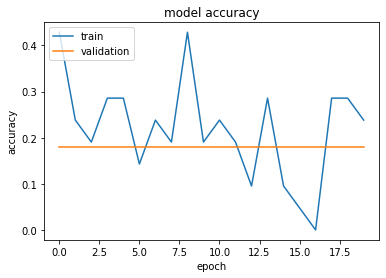

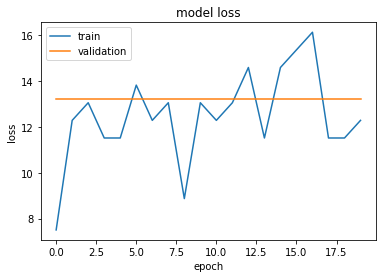

In [59]:
# list all data in history
print(history_02.history.keys())
# summarize history for accuracy
plt.plot(history_02.history['categorical_accuracy'])
plt.plot(history_02.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_02.history['loss'])
plt.plot(history_02.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Reducing batch size=20
# Experiment 2 c
# image =(120,120), lr= .001

#conv3d->MaxPooling3D->Dropout->conv3d->MaxPooling3D->Dropout->Flatten->Dense->Dense(softmax)

In [12]:
import cv2
x = 30   # no. of images of the image
y = 120  # width y dimesnion of the image
z = 120  # height z of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray
no_classes = 5
# number of epochs =20, batch size = 20
batch_size = 20
num_epochs = 20

# Create the model
model_03 = Sequential()
model_03.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30,120,120,3)))
model_03.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_03.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model_03.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_03.add(Flatten())
model_03.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model_03.add(Dense(no_classes, activation='softmax'))

#  compile your model before using it
optimiser_03 = optimizers.Adam(lr=0.001) #write your optimizer
model_03.compile(optimizer=optimiser_03, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_03.summary())
#

train_generator_03 = generator(train_path, train_doc, batch_size)
val_generator_03 = generator(val_path, val_doc, batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 28, 118, 118, 32)  2624      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 14, 59, 59, 32)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 12, 57, 57, 64)    55360     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 6, 28, 28, 64)     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 301056)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               77070592  
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total para

In [13]:
curr_dt_time = datetime.datetime.now()
model_name03 = 'model03_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name03):
    os.mkdir(model_name03)
        
filepath = model_name03 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR03 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR03]

In [14]:

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [15]:
history_03 = model_03.fit_generator(train_generator_03, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_03, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 1100s 32s/step - loss: 12.9346 - categorical_accuracy: 0.1766 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model03_init_2020-06-2813_02_18.061615/model-00001-12.85532-0.18100-13.53920-0.16000.h5
Epoch 2/20
34/34 [==============================] - 278s 8s/step - loss: 12.7997 - categorical_accuracy: 0.2059 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model03_init_2020-06-2813_02_18.061615/model-00002-12.79966-0.20588-13.53920-0.16000.h5
Epoch 3/20
34/34 [==============================] - 278s 8s/step - loss: 12.3256 - categorical_accuracy: 0.2353 - val_loss: 13.5392 - val_categorical_ac

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


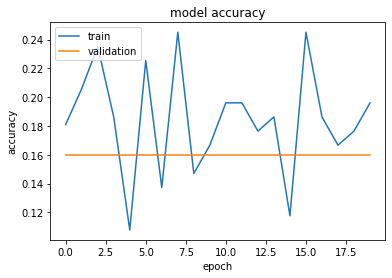

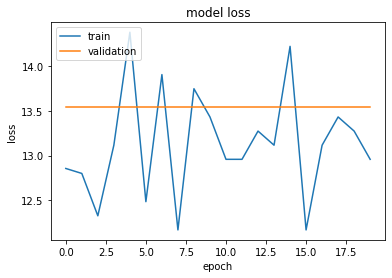

In [18]:
# list all data in history
import matplotlib.pyplot as plt

plot(history_03)

In [6]:
def generator_2(source_path, folder_list, batch_size,x,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:y, 20:y] 
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (y,z),interpolation = cv2.INTER_AREA) 
                    
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                  
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:y, 20:y] #cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) #skimage.transform.resize(image,(120,120))  
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (y,z),interpolation = cv2.INTER_AREA) 
                   
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [7]:
def model_init(model_init,num_train_sequences,batch_size,num_val_sequences):
    
    curr_dt_time = datetime.datetime.now()
    model_name = model_init + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    # LR = 
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1  
        
    return validation_steps,steps_per_epoch,callbacks_list

# Experiment 3a
# conv3D with batch_size =10 and num_epochs=10
# With 4 layers apart & output
#lr=.001
#conv3D->BN->Max3DPooling->conv3D->BN->Max3DPooling->conv3D->BN->Max3DPooling->
#conv3D->BN->DropOut->Max3DPooling->Flatten->Dense->DropOut->Dense->Dropout->Dense(softmax)

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)# tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
# train_doc = np.random.permutation(open('./train.csv').readlines())
# val_doc = np.random.permutation(open('./val.csv').readlines())
train_doc = np.random.permutation(open('C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
# Parameters initialization
x = 30   # no. of images of the video
y = 120  # width y dimesnion of the image
z = 120  # height z of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) 

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:140] #cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) #skimage.transform.resize(image,(120,120))  
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                    #print(t_image.shape)
                    
                 
                    #print(t_image[0].shape)
                    #print(t_image[1].shape)
                    #print(t_image[2].shape)
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:140] #cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) #skimage.transform.resize(image,(120,120))  
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
# curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
#write your model1 here

nb_filters = [8,16,32,64]
#nb_dense = [1000, 500, 5]
nb_dense = [256, 128, 5]

# Input
#input_shape=(nb_frames,width,height,nb_channel)
input_shape =(30,120,120,3)


# Define model1
model1 = Sequential()

# layer 1
model1.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 2
model1.add(Conv3D(16,kernel_size=(3,3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 3
model1.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 4
model1.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model1.add(Activation('relu'))
model1.add(Dropout(0.25))

model1.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model1.add(Flatten())
# dense1
model1.add(Dense(nb_dense[0], activation='relu'))
model1.add(Dropout(0.5))
# dense2
model1.add(Dense(nb_dense[1], activation='relu'))
model1.add(Dropout(0.5))

#softmax layer, output classes
model1.add(Dense(nb_dense[2], activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser1 = optimizers.Adam(lr=0.001) #write your optimizer
model1.compile(optimizer=optimiser1, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator1 = generator(train_path, train_doc, batch_size)
val_generator1 = generator(val_path, val_doc, batch_size)

In [11]:
curr_dt_time = datetime.datetime.now()
model_name1 = 'model1_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name1):
    os.mkdir(model_name1)
        
filepath = model_name1 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR1 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list1 = [checkpoint, LR1]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
model1.fit_generator(train_generator1, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list1, validation_data=val_generator1, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
Source path = Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 10
 C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 10
67/67 [==============================] - 1285s 19s/step - loss: 1.9203 - categorical_accuracy: 0.2157 - val_loss: 1.5655 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model1_init_2020-06-2408_35_27.714227/model-00001-1.92525-0.21569-1.56547-0.24000.h5
Epoch 2/10
67/67 [==============================] - 466s 7s/step - loss: 1.6237 - categorical_accuracy: 0.2736 - val_loss: 1.5951 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model1_init_2020-06-2408_35_27.714227/model-00002-1.62370-0.27363-1.59514-0.29000.h5
Epoch 3/10
67/67 [==============================] - 477s 7s/step - loss: 1.5737 - categorical_accuracy: 0.3682 - val_loss: 1.5975 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model1_init_2020-06

# Experiment 3b
# conv3d with batch_size =10 and num_epochs=20
#lr=.001
#conv3D->BN->Max3DPooling->conv3D->BN->Max3DPooling->conv3D->BN->Max3DPooling->
#conv3D->BN->DropOut->Max3DPooling->Flatten->Dense->DropOut->Dense->Dropout->Dense(softmax)

In [14]:
nb_filters = [8,16,32,64]
#nb_dense = [1000, 500, 5]
nb_dense = [256, 128, 5]

# Input
# the input of the model is a set of images/frames. So the input shape (i.e. one sample's shape) is:
#input_shape=(nb_frames,width,height,nb_channel)
input_shape =(30,120,120,3)

# Define model12
model12 = Sequential()

# layer 1
model12.add(Conv3D(8, kernel_size=(3,3,3),input_shape=input_shape,padding='same'))
model12.add(BatchNormalization())
model12.add(Activation('relu'))

model12.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 2
model12.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model12.add(BatchNormalization())
model12.add(Activation('relu'))

model12.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 3
model12.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model12.add(BatchNormalization())
model12.add(Activation('relu'))

model12.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 4
model12.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model12.add(Activation('relu'))
model12.add(Dropout(0.25))

model12.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model12.add(Flatten())

model12.add(Dense(nb_dense[0], activation='relu'))
model12.add(Dropout(0.5))

model12.add(Dense(nb_dense[1], activation='relu'))
model12.add(Dropout(0.5))

#softmax layer
model12.add(Dense(nb_dense[2], activation='softmax'))

In [15]:
# increased epoch and same batch_size
batch_size = 10
num_epochs = 20

# Model summary 
optimiser12 = optimizers.Adam(lr=0.001) #write your optimizer
model12.compile(optimizer=optimiser12, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model12.summary())
#
train_generator12 = generator(train_path, train_doc, batch_size)
val_generator12 = generator(val_path, val_doc, batch_size)

#
curr_dt_time = datetime.datetime.now()
model_name12 = 'model12_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name12):
    os.mkdir(model_name12)
        
filepath = model_name12 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR
LR12 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR12]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 16)   

In [16]:
# history1  of model: batch_size = 10, num_epochs = 20 
# increased epoch and same batch_size
history12 = model12.fit_generator(train_generator12, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator12, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 10
Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 10
67/67 [==============================] - 1186s 18s/step - loss: 1.8673 - categorical_accuracy: 0.2881 - val_loss: 1.5167 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model12_init_2020-06-2410_07_09.359268/model-00001-1.87012-0.28808-1.51675-0.46000.h5
Epoch 2/20
67/67 [==============================] - 461s 7s/step - loss: 1.4732 - categorical_accuracy: 0.3881 - val_loss: 1.6060 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model12_init_2020-06-2410_07_09.359268/model-00002-1.47316-0.38806-1.60599-0.22000.h5
Epoch 3/20
67/67 [==============================] - 474s 7s/step - loss: 1.4399 - categorical_accuracy: 0.4378 - val_loss: 1.4463 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model12_init_2020

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


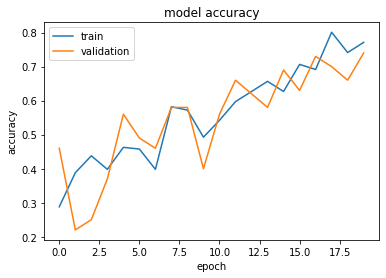

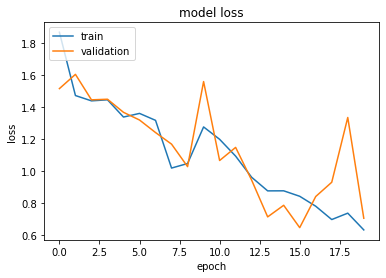

In [17]:
plot2(history12)

# Experiment 3c
# conv3d with batch_size =20 and num_epochs=20
#lr=.001
#conv3D->BN->Max3DPooling->conv3D->BN->Max3DPooling->conv3D->BN->Max3DPooling->
#conv3D->BN->DropOut->Max3DPooling->Flatten->Dense->DropOut->Dense->Dropout->Dense(softmax)

In [18]:
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
#input_shape=(nb_frames,width,height,nb_channel)
input_shape =(30,120,120,3)


# Define model13
model13 = Sequential()

# layer 1
model13.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model13.add(BatchNormalization())
model13.add(Activation('relu'))

model13.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 2
model13.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model13.add(BatchNormalization())
model13.add(Activation('relu'))
model13.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 3
model13.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model13.add(BatchNormalization())
model13.add(Activation('relu'))
model13.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 4
model13.add(Conv3D(64,kernel_size=(1,3,3),padding='same'))
model13.add(Activation('relu'))
model13.add(Dropout(0.25))

model13.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model13.add(Flatten())

model13.add(Dense(nb_dense[0], activation='relu'))
model13.add(Dropout(0.5))

model13.add(Dense(nb_dense[1], activation='relu'))
model13.add(Dropout(0.5))

#softmax layer
model13.add(Dense(nb_dense[2], activation='softmax'))

In [19]:
# history2  of model: batch_size = 20, num_epochs = 20 
# Same epoch and increased batch_size
# model13
batch_size = 20
num_epochs =20 # choose the number of epochs
print ('# epochs =', num_epochs)

# Model summary
optimiser13 = optimizers.Adam(lr=0.001) #write your optimizer
model13.compile(optimizer=optimiser13, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model13.summary())

#
train_generator13 = generator(train_path, train_doc, batch_size)
val_generator13 = generator(val_path, val_doc, batch_size)

#
curr_dt_time = datetime.datetime.now()
model_name13 = 'model13_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name13):
    os.mkdir(model_name13)
        
filepath = model_name13 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR13 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR13]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   
history13 = model13.fit_generator(train_generator13, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator13,
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 20
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_9 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_10 (Activation)   (None, 15, 

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


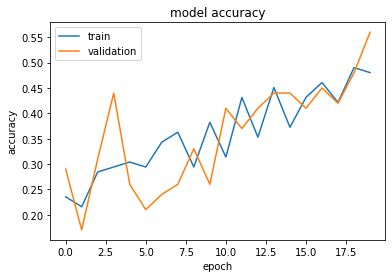

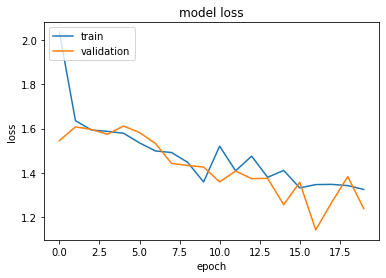

In [20]:
# list all data in history
plot2(history13)

# Experiment 3d
# conv3D with batch_size =20 and num_epochs=20
# two 3D conv block in each convolutional layer
#lr=.001
#conv3D->Conv3D>Max3DPooling->DropOut-->conv3D->Conv3D>Max3DPooling->DropOut->
#conv3D->Conv3D>Max3DPooling->DropOut->conv3D->Conv3D>Max3DPooling->DropOut->
#conv3D->Conv3D>Max3DPooling->DropOut->conv3D->Conv3D>Max3DPooling->DropOut->
#Flatten->Dense->BN->DropOut->Dense(softmax)

In [20]:
# Model -- model_14
input_shape = (30,120,120,3)

batch_size = 20
num_epochs = 20 
# choose the number of epochs
print ('# epochs =', num_epochs)


model_14 = Sequential()

model_14.add(Conv3D(8, kernel_size=(3, 3, 3), input_shape=input_shape, padding='same',name='conv1a'))
model_14.add(Activation('relu'))
model_14.add(Conv3D(8,  kernel_size=(3, 3, 3),padding="same",name='conv1b'))
model_14.add(Activation('relu'))
model_14.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same",name='pool1'))
model_14.add(Dropout(0.25))

model_14.add(Conv3D(16, kernel_size=(3, 3, 3),padding='same',name='conv2a'))
model_14.add(Activation('relu'))
model_14.add(Conv3D(16, kernel_size=(3, 3, 3), padding="same",name='conv2b'))
model_14.add(Activation('relu'))
model_14.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same",name='pool2'))
model_14.add(Dropout(0.25))

model_14.add(Conv3D(32,  kernel_size=(3, 3, 3),padding="same",name='conv3a'))
model_14.add(Activation('relu'))
model_14.add(Conv3D(32, kernel_size=(3, 3, 3),padding="same",name='conv3b'))
model_14.add(Activation('relu'))
model_14.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same",name='pool3'))
model_14.add(Dropout(0.25))

model_14.add(Conv3D(32, kernel_size=(3, 3, 3),padding="same",name='conv4a'))
model_14.add(Activation('relu'))
model_14.add(Conv3D(32, kernel_size=(3, 3, 3),padding="same",name='conv4b'))
model_14.add(Activation('relu'))
model_14.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same",name='pool4'))
model_14.add(Dropout(0.25))

model_14.add(Conv3D(64,kernel_size=(3, 3, 3),padding="same",name='conv5a'))
model_14.add(Activation('relu'))
model_14.add(Conv3D(64, kernel_size=(3, 3, 3),padding="same",name='conv5b'))
model_14.add(Activation('relu'))
model_14.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same",name='pool5'))
model_14.add(Dropout(0.25))

model_14.add(Conv3D(128,kernel_size=(3, 3, 3),padding="same",name='conv6a'))
model_14.add(Activation('relu'))
model_14.add(Conv3D(128,kernel_size=(3, 3, 3),padding="same", name='conv6b'))
model_14.add(Activation('relu'))
model_14.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same",name='pool6'))
model_14.add(Dropout(0.25))


model_14.add(Flatten())
#dense1
model_14.add(Dense(512, activation='relu'))
model_14.add(BatchNormalization())
model_14.add(Dropout(0.5))

model_14.add(Dense(5, activation='softmax'))


# Model summary
optimiser14 = optimizers.Adam(lr=0.001) #write your optimizer
model_14.compile(optimizer=optimiser14, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_14.summary())

# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (Conv3D)              (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_13 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
conv1b (Conv3D)              (None, 30, 120, 120, 8)   1736      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 10, 40, 40, 8)     0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 40, 40, 8)     0         
_________________________________________________________________
conv2a (Conv3D)              (None, 10, 40, 40, 16)    3472   

In [21]:
#
train_generator14 = generator(train_path, train_doc, batch_size)
val_generator14 = generator(val_path, val_doc, batch_size)

#
curr_dt_time = datetime.datetime.now()
model_name14 = 'model14_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name14):
    os.mkdir(model_name14)
        
filepath = model_name14 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR14 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR14]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   


In [22]:
history14 = model_14.fit_generator(train_generator14, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator14,
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 517s 15s/step - loss: 1.5468 - categorical_accuracy: 0.2421 - val_loss: 1.4454 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model14_init_2020-06-2814_53_34.658318/model-00001-1.54668-0.23982-1.44544-0.21000.h5
Epoch 2/20
34/34 [==============================] - 125s 4s/step - loss: 1.6093 - categorical_accuracy: 0.2353 - val_loss: 1.9948 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model14_init_2020-06-2814_53_34.658318/model-00002-1.60930-0.23529-1.99480-0.16000.h5
Epoch 3/20
34/34 [==============================] - 125s 4s/step - loss: 1.4870 - categorical_accuracy: 0.3431 - val_loss: 1.2262 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model14_init_2

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


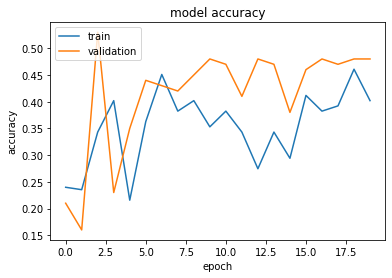

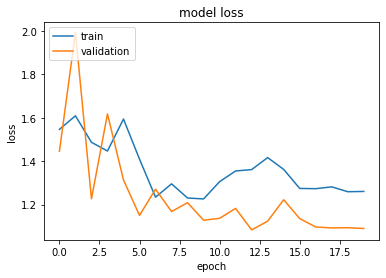

In [23]:
# list all data in history
plot2(history14)

# Experiment 3e
# batch_size = 10, num_epochs=20
# Conv3D
conv3D->BN->Relu->Max3DPooling->conv3D->BN->Relu->Max3DPooling->conv3D->BN->Relu->Max3DPooling->
conv3D->BN->Relu->Max3DPooling-Flatten->Dense(64)->Dropout->Dense(64)->Dropout->Dense(softmax)
# Default learning rate for optimizer
#image_size =(120,120)

In [63]:
# curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
batch_size = 10
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 10


In [67]:
nb_filters = [8,16,32,64]
nb_dense = [64, 5]
x=30
y=120
z=120
# Input
#input_shape=(nb_frames,width,height,nb_channel)
input_shape =(x,y,z,3)


# Define model3e
model3e = Sequential()

# layer 1
model3e.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model3e.add(BatchNormalization())
model3e.add(Activation('relu'))
model3e.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 2
model3e.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model3e.add(BatchNormalization())
model3e.add(Activation('relu'))
model3e.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 3
model3e.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model3e.add(BatchNormalization())
model3e.add(Activation('relu'))
model3e.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 4
model3e.add(Conv3D(64,kernel_size=(3,3,3),padding='same'))
model3e.add(BatchNormalization())
model3e.add(Activation('relu'))
model3e.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model3e.add(Flatten())

model3e.add(Dense(nb_dense[0], activation='relu'))
model3e.add(Dropout(0.5))

model3e.add(Dense(nb_dense[0], activation='relu'))
model3e.add(Dropout(0.5))

#softmax layer
model3e.add(Dense(nb_dense[1], activation='softmax'))

train_generator3e= generator_2(train_path, train_doc, batch_size,x,y,z)
val_generator3e = generator_2( val_path, val_doc, batch_size,x,y,z)

optimiser = optimizers.Adam() #write your optimizer, with default learning rate
model3e.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3e.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_34 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_9 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_35 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_10 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [68]:
validation_steps,steps_per_epoch,callbacks_list = model_init('model3e_init',num_train_sequences,batch_size,num_val_sequences)
history_model3e = model3e.fit_generator(train_generator3e, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3e, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 10
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 10
67/67 [==============================] - 647s 10s/step - loss: 1.9047 - categorical_accuracy: 0.2777 - val_loss: 1.5684 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model3e_init_2020-06-3018_32_30.914923/model-00001-1.90780-0.28054-1.56842-0.24000.h5
Epoch 2/20
67/67 [==============================] - 350s 5s/step - loss: 1.6078 - categorical_accuracy: 0.1940 - val_loss: 1.6067 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model3e_init_2020-06-3018_32_30.914923/model-00002-1.60783-0.19403-1.60666-0.23000.h5
Epoch 3/20
67/67 [==============================] - 352s 5s/step - loss: 1.6057 - categorical_accuracy: 0.2040 - val_loss: 1.5796 - val_categorical_accuracy: 0.3200

Epoch 00003: saving model to model3e_init_2

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


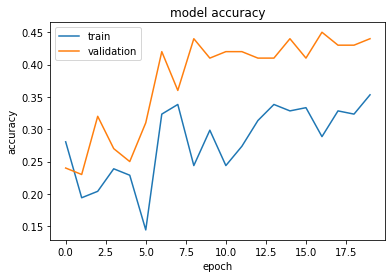

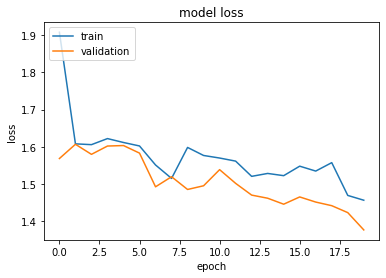

In [71]:
plot2(history_model3e)

# Experiment 3f
# Conv3D
# Modify model 3e with varying number of neuron / units in dense
# batch_size = 10
# num_epochs = 20
# default learning rate for optimizer
#image_size =(120,120)
#conv3D->BN->Relu->Max3DPooling->conv3D->BN->Relu->Max3DPooling->conv3D->BN->Relu->Max3DPooling->
#conv3D->BN->Relu->Max3DPooling-Flatten->Dense(256)->Dropout->Dense(128)->Dropout->Dense(softmax)

In [72]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
batch_size = 10
num_epochs = 20  # choose the number of epochs
x = 30
y = 120
z = 120
print ('# epochs =', num_epochs)
print ('# batch size =', batch_size)
##
nb_filters = [16,32,64,128]
nb_dense = [256,128, 5]
input_shape =(x,y,z,3)


# Define model3f
model3f = Sequential()

# layer 1
model3f.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model3f.add(BatchNormalization())
model3f.add(Activation('relu'))
model3f.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 2
model3f.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model3f.add(BatchNormalization())
model3f.add(Activation('relu'))
model3f.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 3
model3f.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model3f.add(BatchNormalization())
model3f.add(Activation('relu'))
model3f.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 4
model3f.add(Conv3D(128,kernel_size=(3,3,3),padding='same'))
model3f.add(BatchNormalization())
model3f.add(Activation('relu'))
model3f.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model3f.add(Flatten())

model3f.add(Dense(nb_dense[0], activation='relu'))
model3f.add(Dropout(0.5))

model3f.add(Dense(nb_dense[1], activation='relu'))
model3f.add(Dropout(0.5))

#softmax layer
model3f.add(Dense(nb_dense[2], activation='softmax'))



##
train_generator3f= generator_2(train_path, train_doc, batch_size,x,y,z)
val_generator3f = generator_2( val_path, val_doc, batch_size, x,y,z)

optimiser = optimizers.Adam() #write your optimizer, with default learning rate
model3f.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3f.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_38 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_13 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_39 (Batc (None, 15, 60, 60, 32)    128       
______________________________________________________

In [73]:
validation_steps,steps_per_epoch,callbacks_list = model_init('model3f_init',num_train_sequences,batch_size,num_val_sequences)

history_model3f = model3f.fit_generator(train_generator3f, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3f, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 10
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 10
67/67 [==============================] - 991s 15s/step - loss: 9.0830 - categorical_accuracy: 0.2393 - val_loss: 2.3331 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model3f_init_2020-06-3020_40_14.868401/model-00001-9.12307-0.23831-2.33311-0.25000.h5
Epoch 2/20
67/67 [==============================] - 459s 7s/step - loss: 1.6552 - categorical_accuracy: 0.2637 - val_loss: 1.4889 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model3f_init_2020-06-3020_40_14.868401/model-00002-1.65522-0.26368-1.48894-0.22000.h5
Epoch 3/20
67/67 [==============================] - 463s 7s/step - loss: 1.5508 - categorical_accuracy: 0.3184 - val_loss: 1.2581 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model3f_init_2

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


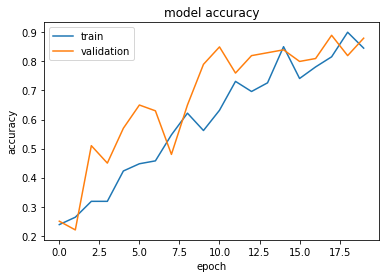

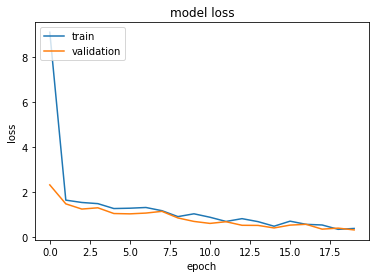

In [74]:
plot2(history_model3f)

## Experiment 3g
# Conv3D
# Dense has varying number of neuron / units
# batch_size =20
# num_epochs = 15 
# default learning rate for optimizer
# use model 3f
conv3D->BN->Relu->Max3DPooling->conv3D->BN->Relu->Max3DPooling->conv3D->BN->Relu->Max3DPooling->
conv3D->BN->Relu->Max3DPooling-Flatten->Dense(256)->Dropout->Dense(128)->Dropout->Dense(softmax)
#image_size =(160,160)

In [18]:
# curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
batch_size = 20
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 15
# batch size = 20


In [19]:
# Define model13g
x = 30
y = 160
z = 160
input_shape = (x,y,z,3)
nb_filters = [16,32,64,128]
nb_dense = [256,128, 5]
input_shape =(x,y,z,3)
model3g = Sequential()

# layer 1
model3g.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model3g.add(BatchNormalization())
model3g.add(Activation('relu'))
model3g.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 2
model3g.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model3g.add(BatchNormalization())
model3g.add(Activation('relu'))
model3g.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 3
model3g.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model3g.add(BatchNormalization())
model3g.add(Activation('relu'))
model3g.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 4
model3g.add(Conv3D(128,kernel_size=(3,3,3),padding='same'))
model3g.add(BatchNormalization())
model3g.add(Activation('relu'))
model3g.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model3g.add(Flatten())

model3g.add(Dense(nb_dense[0], activation='relu'))
model3g.add(Dropout(0.5))

model3g.add(Dense(nb_dense[1], activation='relu'))
model3g.add(Dropout(0.5))

#softmax layer
model3g.add(Dense(nb_dense[2], activation='softmax'))

In [20]:
x = 30
y = 160
z = 160
print ('# epochs =', num_epochs)
print ('# batch size =', batch_size)

train_generator3g= generator_2(train_path, train_doc, batch_size,x,y,z)
val_generator3g  = generator_2( val_path, val_doc, batch_size, x,y,z)

optimiser = optimizers.Adam() #write your optimizer, with default learning rate
model3g.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3g.summary())

# epochs = 15
# batch size = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
activation_9 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 80, 80, 32)    128       
_________________________________________________________________
activation_10 (Activation)   (None, 15, 80, 

In [21]:
validation_steps,steps_per_epoch,callbacks_list = model_init('model3g_init',num_train_sequences,batch_size,num_val_sequences)

history_model3g = model3g.fit_generator(train_generator3g, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3g, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 1556s 46s/step - loss: 10.6714 - categorical_accuracy: 0.2134 - val_loss: 11.9592 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model3g_init_2020-07-0116_45_09.951894/model-00001-10.65012-0.21870-11.95920-0.22000.h5
Epoch 2/15
34/34 [==============================] - 424s 12s/step - loss: 8.6684 - categorical_accuracy: 0.1863 - val_loss: 5.4383 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model3g_init_2020-07-0116_45_09.951894/model-00002-8.66841-0.18627-5.43830-0.30000.h5
Epoch 3/15
34/34 [==============================] - 427s 13s/step - loss: 1.7340 - categorical_accuracy: 0.2255 - val_loss: 1.3929 - val_categorical_accuracy: 0.3900

Epoch 00003: saving model to model3g

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


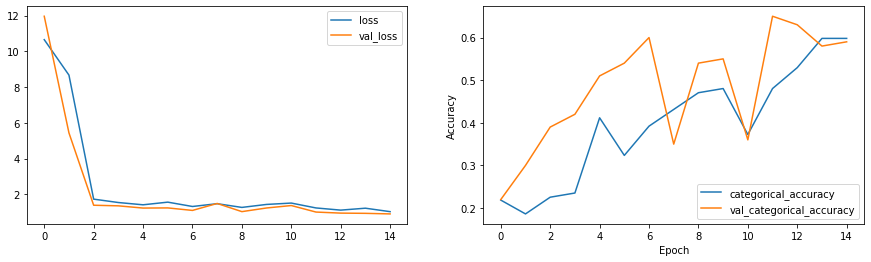

In [22]:
plot(history_model3g)

#Conv3D
Dense has varying number of neuron / units
batch_size =20
num_epochs = 15
# default learning rate for optimizer and the two dense layer have l1 activity regularizer
use model 3f
conv3D(16)->BN->Relu->Max3DPooling->conv3D(32)->BN->Relu->Max3DPooling->conv3D(64)->BN->Relu->Max3DPooling-> 
conv3D(128)->BN->Relu->Max3DPooling->conv3D(256)->BN->Relu->Max3DPooling->Flatten->
Dense(256)->Dropout->Dense(128)->Dropout->Dense(softmax)
#image_size =(160,160)

In [13]:
# Define model3g_5
x = 30
y = 120
z = 120
from keras.regularizers import l1
input_shape = (x,y,z,3)
model3g_5 = Sequential()

# layer 1
model3g_5.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model3g_5.add(BatchNormalization())
model3g_5.add(Activation('relu'))
model3g_5.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 2
model3g_5.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model3g_5.add(BatchNormalization())
model3g_5.add(Activation('relu'))
model3g_5.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 3
model3g_5.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model3g_5.add(BatchNormalization())
model3g_5.add(Activation('relu'))
model3g_5.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 4
model3g_5.add(Conv3D(128,kernel_size=(3,3,3),padding='same'))
model3g_5.add(BatchNormalization())
model3g_5.add(Activation('relu'))
model3g_5.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model3g_5.add(Flatten())

model3g_5.add(Dense(nb_dense[0], activation='relu', activity_regularizer=l1(0.0001)))
model3g_5.add(Dropout(0.5))

model3g_5.add(Dense(nb_dense[1], activation='relu', activity_regularizer=l1(0.0001)))
model3g_5.add(Dropout(0.5))

#softmax layer
model3g_5.add(Dense(nb_dense[2], activation='softmax'))

In [14]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
batch_size = 20
num_epochs = 15 # choose the number of epochs
x = 30
y = 120
z = 120
print ('# epochs =', num_epochs)
print ('# batch size =', batch_size)

train_generator3g5= generator_2(train_path, train_doc, batch_size,x,y,z)
val_generator3g5  = generator_2( val_path, val_doc, batch_size, x,y,z)

optimiser = optimizers.Adam() #write your optimizer, with default learning rate
model3g_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3g_5.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 15
# batch size = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 60, 60, 32)    128       
______________________________________________________

In [15]:
validation_steps,steps_per_epoch,callbacks_list = model_init('model3g5_init',num_train_sequences,batch_size,num_val_sequences)

history_model3g5 = model3g_5.fit_generator(train_generator3g5, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3g5, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 878s 26s/step - loss: 3.4923 - categorical_accuracy: 0.2531 - val_loss: 1.6250 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model3g5_init_2020-07-0115_32_14.957222/model-00001-3.54245-0.25943-1.62502-0.29000.h5
Epoch 2/15
34/34 [==============================] - 239s 7s/step - loss: 1.6302 - categorical_accuracy: 0.2353 - val_loss: 1.4578 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model3g5_init_2020-07-0115_32_14.957222/model-00002-1.63017-0.23529-1.45784-0.30000.h5
Epoch 3/15
34/34 [==============================] - 234s 7s/step - loss: 1.7668 - categorical_accuracy: 0.2549 - val_loss: 2.0751 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model3g5_ini

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


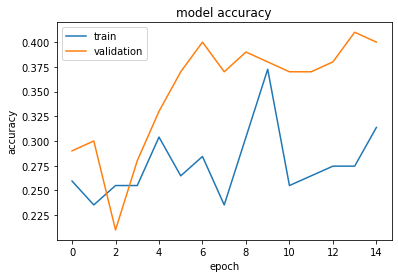

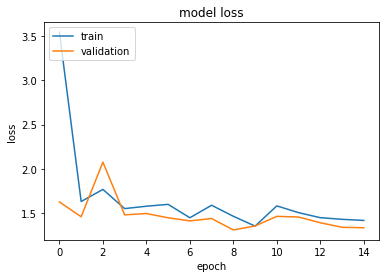

In [16]:
plot2(history_model3g5)

The padding parameter to the Keras Conv2D class can take on one of two values: valid or same .

With the valid parameter the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.

The following example would naturally reduce the spatial dimensions of our volume:

Keras Conv2D and Convolutional Layers
model.add(Conv2D(32, (3, 3), padding="valid"))


If we instead want to preserve the spatial dimensions of the volume such that the output volume size matches the input volume size, then we would want to supply a value of same for the padding :

Keras Conv2D and Convolutional Layers
model.add(Conv2D(32, (3, 3), padding="same"))
While the default Keras Conv2D value is valid I will typically set it to same for the majority of the layers in my network and then either reduce spatial dimensions of my volume by either:
Max pooling
Strided convolution

# Experiment 4a
# conv2D with batch_size =20 and num_epochs=20

# input has  7 x 7 filter
# following layers have 3 x 3 filter
# stride (2,2) to reduce the size of the output volume
#Conv2D +LSTM
#lr =.001
#TimeDistributed Conv2D->TimeDIstributed Conv2D->MaxPooling2D->
#TimeDistributed Conv2D->TimeDIstributed Conv2D->MaxPooling2D->
#TimeDistributed Conv2D->TimeDIstributed Conv2D->MaxPooling2D->
#TimeDistributed Conv2D->TimeDIstributed Conv2D->MaxPooling2D->Flatten->DropOut->LSTM->Softmax

In [21]:
# Model 2 conv2D + LSTM
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.regularizers import l2
from keras.layers.recurrent import LSTM
#input_shape=(nb_frames,width,height,nb_channel)
batch_size  = 20
epochs      = 20
y = 120
z = 120
# the input of the model is a set of images/frames. So the input shape (i.e. one sample's shape) is:
#input_shape=(nb_frames,width,height,nb_channel)
input_shape =(30,120,120,3)
nb_classes  = 5

model2 = Sequential()
# 7 x 7 filter
model2.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
# layer 1, 3 x 3 filter
model2.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
# layer 2
model2.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model2.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
# layer 3
model2.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model2.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
# layer 4
model2.add(TimeDistributed(Conv2D(256, (3,3),padding='same', activation='relu')))
model2.add(TimeDistributed(Conv2D(256, (3,3),padding='same', activation='relu')))
model2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# flatten layer
model2.add(TimeDistributed(Flatten()))
model2.add(Dropout(0.5))
# LSTM layer
model2.add(LSTM(256, return_sequences=False, dropout=0.5))
# last layer
model2.add(Dense(nb_classes, activation='softmax'))

In [22]:
optimiser2 = optimizers.Adam(lr=0.001) #write your optimizer
model2.compile(optimizer=optimiser2, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 32)    4736      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 58, 58, 32)    9248      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 29, 29, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 29, 29, 64)    36928     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 14, 14, 64)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 14, 14, 128)  

In [23]:
#
train_generator2 = generator(train_path, train_doc, batch_size)
val_generator2 = generator(val_path, val_doc, batch_size)

#
curr_dt_time = datetime.datetime.now()
model_name2 = 'model2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name2):
    os.mkdir(model_name2)
        
filepath = model_name2 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR2]



In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   


In [25]:
model2.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator2, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 1245s 37s/step - loss: 1.5764 - categorical_accuracy: 0.2383 - val_loss: 1.6813 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model2_init_2020-06-2414_47_55.928753/model-00001-1.58221-0.23831-1.68133-0.28000.h5
Epoch 2/20
34/34 [==============================] - 237s 7s/step - loss: 1.6404 - categorical_accuracy: 0.2353 - val_loss: 1.5999 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model2_init_2020-06-2414_47_55.928753/model-00002-1.64039-0.23529-1.59993-0.22000.h5
Epoch 3/20
34/34 [==============================] - 248s 7s/step - loss: 1.6271 - categorical_accuracy: 0.1961 - val_loss: 1.6003 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model2_init_2020-06

# Stacked LSTM

Stacked Long Short-Term Memory Networks
by Jason Brownlee on August 18, 2017 in Long Short-Term Memory Networks
Tweet  Share
Last Updated on August 14, 2019

Gentle introduction to the Stacked LSTM
with example code in Python.
The original LSTM model is comprised of a single hidden LSTM layer followed by a standard feedforward output layer.

The Stacked LSTM is an extension to this model that has multiple hidden LSTM layers where each layer contains multiple memory cells.


After completing this tutorial, you will know:

The benefit of deep neural network architectures.
The Stacked LSTM recurrent neural network architecture.
How to implement stacked LSTMs in Python with Keras.
Discover how to develop LSTMs such as stacked, bidirectional, CNN-LSTM, Encoder-Decoder seq2seq and more in my new book, with 14 step-by-step tutorials and full code.

Let’s get started.

Gentle Introduction to Stacked Long Short-Term Memory Networks
Gentle Introduction to Stacked Long Short-Term Memory Networks
Photo by Joost Markerink, some rights reserved.

Overview
This post is divided into 3 parts, they are:

Why Increase Depth?
Stacked LSTM Architecture
Implement Stacked LSTMs in Keras
Why Increase Depth?
Stacking LSTM hidden layers makes the model deeper, more accurately earning the description as a deep learning technique.

It is the depth of neural networks that is generally attributed to the success of the approach on a wide range of challenging prediction problems.

[the success of deep neural networks] is commonly attributed to the hierarchy that is introduced due to the several layers. Each layer processes some part of the task we wish to solve, and passes it on to the next. In this sense, the DNN can be seen as a processing pipeline, in which each layer solves a part of the task before passing it on to the next, until finally the last layer provides the output.

— Training and Analyzing Deep Recurrent Neural Networks, 2013

Additional hidden layers can be added to a Multilayer Perceptron neural network to make it deeper. The additional hidden layers are understood to recombine the learned representation from prior layers and create new representations at high levels of abstraction. For example, from lines to shapes to objects.

A sufficiently large single hidden layer Multilayer Perceptron can be used to approximate most functions. Increasing the depth of the network provides an alternate solution that requires fewer neurons and trains faster. Ultimately, adding depth it is a type of representational optimization.

Deep learning is built around a hypothesis that a deep, hierarchical model can be exponentially more efficient at representing some functions than a shallow one.

— How to Construct Deep Recurrent Neural Networks, 2013.



Stacked LSTM Architecture
The same benefits can be harnessed with LSTMs.

Given that LSTMs operate on sequence data, it means that the addition of layers adds levels of abstraction of input observations over time. In effect, chunking observations over time or representing the problem at different time scales.

… building a deep RNN by stacking multiple recurrent hidden states on top of each other. This approach potentially allows the hidden state at each level to operate at different timescale

— How to Construct Deep Recurrent Neural Networks, 2013

Stacked LSTMs or Deep LSTMs were introduced by Graves, et al. in their application of LSTMs to speech recognition, beating a benchmark on a challenging standard problem.

RNNs are inherently deep in time, since their hidden state is a function of all previous hidden states. The question that inspired this paper was whether RNNs could also benefit from depth in space; that is from stacking multiple recurrent hidden layers on top of each other, just as feedforward layers are stacked in conventional deep networks.

— Speech Recognition With Deep Recurrent Neural Networks, 2013

In the same work, they found that the depth of the network was more important than the number of memory cells in a given layer to model skill.

Stacked LSTMs are now a stable technique for challenging sequence prediction problems. A Stacked LSTM architecture can be defined as an LSTM model comprised of multiple LSTM layers. An LSTM layer above provides a sequence output rather than a single value output to the LSTM layer below. Specifically, one output per input time step, rather than one output time step for all input time steps.

Refferred Link:
https://machinelearningmastery.com/stacked-long-short-term-memory-networks/#:~:text=A%20Stacked%20LSTM%20architecture%20can,for%20all%20input%20time%20steps.
https://stats.stackexchange.com/questions/163304/what-are-the-advantages-of-stacking-multiple-lstms

# Experiment 4b
# conv2D with batch_size =20 and num_epochs=20
# conv2D with stacked LSTM - 2 hidden layers
# number of filters 32 each
#Conv2D +StackedLSTM
#lr =.001
#TimeDistributed Conv2D->TimeDIstributed axPooling2D->
#TimeDistributed  Flatten->LSTM(32)->LSTM(32)
#->Flatten->Softmax


In [39]:
#Model-- model21

num_epochs = 20
batch_size = 20

input_shape = (30,120,120,3)

model21 = Sequential()
# define CNN model
model21.add(TimeDistributed(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu')))
model21.add(TimeDistributed(MaxPooling2D(pool_size = (2, 2))))
model21.add(TimeDistributed(Flatten()))
# define stacked LSTM model - 2 hidden layers
model21.add(LSTM(32, return_sequences=True))
model21.add(LSTM(32, return_sequences=True))
# with a three dimensional layer - reduce the dimensionality
model21.add(Flatten())
model21.add(Dense(5, activation='softmax'))
model21.build((None,) + input_shape)

optimiser21 = optimizers.Adam(lr=0.001) #write your optimizer
model21.compile(optimizer=optimiser21, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model21.summary())


#************************
train_generator21 = generator(train_path, train_doc, batch_size)
val_generator21 = generator(val_path, val_doc, batch_size)

#*************************
curr_dt_time = datetime.datetime.now()
model_name21 = 'model21_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name21):
    os.mkdir(model_name21)
        
filepath = model_name21 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR21 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR21]

#**************************
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_37 (TimeDis (None, 30, 118, 118, 32)  896       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 30, 59, 59, 32)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 30, 111392)        0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 30, 32)            14262400  
_________________________________________________________________
lstm_26 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
flatten_18 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 4805      
Total para

In [40]:
#***************************
history_21 = model21.fit_generator(train_generator21, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator21,
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 138s 4s/step - loss: 1.5760 - categorical_accuracy: 0.2789 - val_loss: 1.5731 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model21_init_2020-06-2816_22_07.949354/model-00001-1.58066-0.27753-1.57309-0.25000.h5
Epoch 2/20
34/34 [==============================] - 49s 1s/step - loss: 1.7238 - categorical_accuracy: 0.1275 - val_loss: 1.6149 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model21_init_2020-06-2816_22_07.949354/model-00002-1.72376-0.12745-1.61492-0.22000.h5
Epoch 3/20
34/34 [==============================] - 49s 1s/step - loss: 1.6104 - categorical_accuracy: 0.2255 - val_loss: 1.5333 - val_categorical_accuracy: 0.3600

Epoch 00003: saving model to model21_init_2020

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


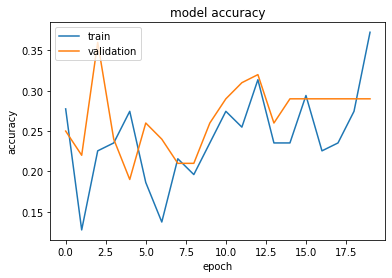

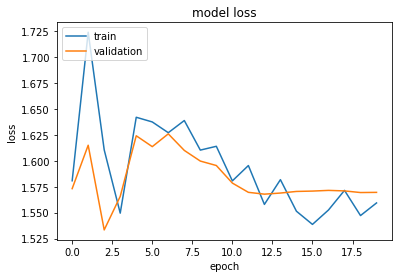

In [41]:
# list all data in history
plot2(history_21)


# Experiment 4c
# conv2D with batch_size =20 and num_epochs=20
# conv2D + stacked LSTM
# conv2D with stacked LSTM -3 hidden layers
# number of filters 32 each
#Conv2D +StackedLSTM
#lr =.001
#TimeDistributed Conv2D->TimeDIstributed axPooling2D->
#TimeDistributed  Flatten->LSTM(32)->LSTM(32)->LSTM(32)
#->Flatten->Softmax

In [42]:
#Model-- model22
num_epochs = 20
batch_size = 20
input_shape = (30,120,120,3)

model22 = Sequential()
# define CNN model
model22.add(TimeDistributed(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu')))
model22.add(TimeDistributed(MaxPooling2D(pool_size = (2, 2))))
model22.add(TimeDistributed(Flatten()))
# define stacked LSTM model - 3 hidden layers
model22.add(LSTM(32, return_sequences=True))
model22.add(LSTM(32, return_sequences=True))
model22.add(LSTM(32, return_sequences=True))
model22.add(Flatten())
model22.add(Dense(5, activation='softmax'))
model22.build((None,) + input_shape)

        
filepath = model_name22 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR22 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR22]

#**************************
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_40 (TimeDis (None, 30, 118, 118, 32)  896       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 30, 59, 59, 32)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 30, 111392)        0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 30, 32)            14262400  
_________________________________________________________________
lstm_28 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
lstm_29 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
flatten_20 (Flatten)         (None, 960)               0         
__________

In [43]:
#***************************
history_22 = model22.fit_generator(train_generator22, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator22,
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 129s 4s/step - loss: 1.5406 - categorical_accuracy: 0.2943 - val_loss: 1.4885 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model22_init_2020-06-2816_39_54.359963/model-00001-1.54626-0.28507-1.48854-0.35000.h5
Epoch 2/20
34/34 [==============================] - 48s 1s/step - loss: 1.4422 - categorical_accuracy: 0.3431 - val_loss: 1.5468 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model22_init_2020-06-2816_39_54.359963/model-00002-1.44224-0.34314-1.54684-0.31000.h5
Epoch 3/20
34/34 [==============================] - 48s 1s/step - loss: 1.5548 - categorical_accuracy: 0.2941 - val_loss: 1.4685 - val_categorical_accuracy: 0.3200

Epoch 00003: saving model to model22_init_2020

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


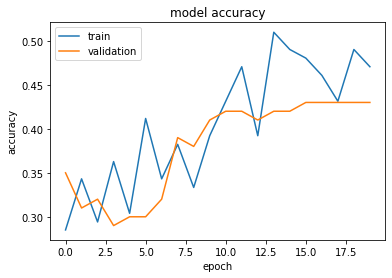

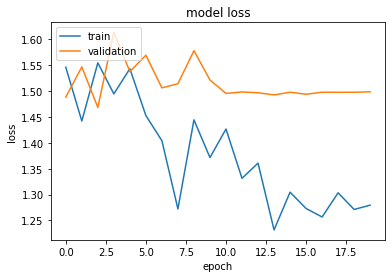

In [44]:
# list all data in history
plot2(history_22)

# Experiment 4c
# conv2D with batch_size =20 and num_epochs=20

# input has  3 x 3 filter
# Conv2D following layers have 3 x 3 filter
# a LSTM layer for  feature extraction followed by output layer
#Conv2D +LSTM
#lr =.001
#TimeDistributed Conv2D->TimeDIstributed Conv2D->MaxPooling2D->
#TimeDistributed Conv2D->TimeDIstributed Conv2D->MaxPooling2D->
#TimeDistributed Conv2D->TimeDIstributed Conv2D->MaxPooling2D->
#TimeDistributed Conv2D->TimeDIstributed Conv2D->MaxPooling2D->Flatten->DropOut->LSTM->Softmax

In [45]:
# Model 2 conv2D + LSTM
from keras.layers.convolutional import Conv2D,MaxPooling2D

from keras.layers.recurrent import LSTM
#input_shape=(nb_frames,width,height,nb_channel)
batch_size  = 20
epochs      = 20
y = 120
z = 120
# the input of the model is a set of images/frames. So the input shape (i.e. one sample's shape) is:
#input_shape=(nb_frames,width,height,nb_channel)
input_shape =(30,120,120,3)
nb_classes  = 5

model23 = Sequential()
# 3 x 3 filter
model23.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
# layer 1
model23.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model23.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
# layer 2
model23.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model23.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model23.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
# layer 3
model23.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model23.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model23.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
# layer 4
model23.add(TimeDistributed(Conv2D(256, (3,3),padding='same', activation='relu')))
model23.add(TimeDistributed(Conv2D(256, (3,3),padding='same', activation='relu')))
model23.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# flatten layer
model23.add(TimeDistributed(Flatten()))
model23.add(Dropout(0.5))
# LSTM layer
model23.add(LSTM(256, return_sequences=False, dropout=0.5))
# last layer
model23.add(Dense(nb_classes, activation='softmax'))

In [46]:
optimiser23 = optimizers.Adam(lr=0.001) #write your optimizer
model23.compile(optimizer=optimiser23, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model23.summary())


#************************
train_generator23 = generator(train_path, train_doc, batch_size)
val_generator23 = generator(val_path, val_doc, batch_size)

#*************************
curr_dt_time = datetime.datetime.now()
model_name23 = 'model23_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name23):
    os.mkdir(model_name23)
        
filepath = model_name23 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR23 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR23]

#**************************
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_43 (TimeDis (None, 30, 60, 60, 32)    896       
_________________________________________________________________
time_distributed_44 (TimeDis (None, 30, 58, 58, 32)    9248      
_________________________________________________________________
time_distributed_45 (TimeDis (None, 30, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_46 (TimeDis (None, 30, 29, 29, 64)    18496     
_________________________________________________________________
time_distributed_47 (TimeDis (None, 30, 29, 29, 64)    36928     
_________________________________________________________________
time_distributed_48 (TimeDis (None, 30, 14, 14, 64)    0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, 30, 14, 14, 128)   73856     
__________

In [47]:
history_23 = model23.fit_generator(train_generator23, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator23,
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 164s 5s/step - loss: 1.6302 - categorical_accuracy: 0.1898 - val_loss: 1.6113 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model23_init_2020-06-2816_57_41.006657/model-00001-1.63032-0.19457-1.61132-0.18000.h5
Epoch 2/20
34/34 [==============================] - 35s 1s/step - loss: 1.6108 - categorical_accuracy: 0.2549 - val_loss: 1.6104 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model23_init_2020-06-2816_57_41.006657/model-00002-1.61085-0.25490-1.61044-0.18000.h5
Epoch 3/20
34/34 [==============================] - 35s 1s/step - loss: 1.6114 - categorical_accuracy: 0.1569 - val_loss: 1.6071 - val_categorical_accuracy: 0.1800

Epoch 00003: saving model to model23_init_2020

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


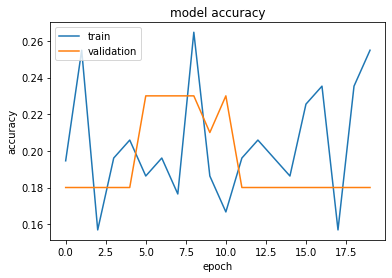

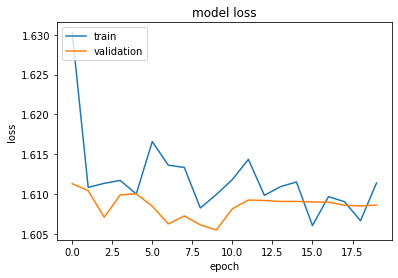

In [48]:
# list all data in history
plot2(history_23)

# Experiment 4d
# conv2D with batch_size =30 and num_epochs=20
# conv2D with stacked LSTM-3 hidden layers
# input has 3 x 3 filter
# following layers have 3 x 3 filter
# number of filters 32 each
#Conv2D +LSTM
#lr =.001
#TimeDistributed Conv2D->TimeDIstributed MaxPooling2D->
#TimeDistributed Flatten->LSTM(32)->LSTM(32)->LSTM(32)->Flatten->Softmax

In [49]:
#Model-- model24
# conv2D with stacked LSTM - 3 hidden layers

num_epochs = 30
batch_size = 20

input_shape = (30,120,120,3)

model24 = Sequential()
# define CNN model
model24.add(TimeDistributed(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu')))
model24.add(TimeDistributed(MaxPooling2D(pool_size = (2, 2))))
model24.add(TimeDistributed(Flatten()))
# define stacked LSTM model - 3 hidden layers
model24.add(LSTM(32, return_sequences=True))
model24.add(LSTM(32, return_sequences=True))
model24.add(LSTM(32, return_sequences=True))
model24.add(Flatten())
model24.add(Dense(5, activation='softmax'))
model24.build((None,) + input_shape)



optimiser24 = optimizers.Adam(lr=0.001) #write your optimizer
model24.compile(optimizer=optimiser24, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model24.summary())


#************************
train_generator24 = generator(train_path, train_doc, batch_size)
val_generator24 = generator(val_path, val_doc, batch_size)

#*************************
curr_dt_time = datetime.datetime.now()
model_name24 = 'model24_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name24):
    os.mkdir(model_name24)
        
filepath = model_name24 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR24 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR24]

#**************************
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_56 (TimeDis (None, 30, 118, 118, 32)  896       
_________________________________________________________________
time_distributed_57 (TimeDis (None, 30, 59, 59, 32)    0         
_________________________________________________________________
time_distributed_58 (TimeDis (None, 30, 111392)        0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 30, 32)            14262400  
_________________________________________________________________
lstm_32 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
lstm_33 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
flatten_23 (Flatten)         (None, 960)               0         
__________

In [50]:
#***************************
history_24 = model24.fit_generator(train_generator24, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator24,
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 131s 4s/step - loss: 1.5116 - categorical_accuracy: 0.3127 - val_loss: 1.5134 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model24_init_2020-06-2817_11_41.168081/model-00001-1.51595-0.31222-1.51335-0.28000.h5
Epoch 2/30
34/34 [==============================] - 49s 1s/step - loss: 1.5939 - categorical_accuracy: 0.2157 - val_loss: 1.5176 - val_categorical_accuracy: 0.2700

Epoch 00002: saving model to model24_init_2020-06-2817_11_41.168081/model-00002-1.59386-0.21569-1.51762-0.27000.h5
Epoch 3/30
34/34 [==============================] - 49s 1s/step - loss: 1.4989 - categorical_accuracy: 0.2549 - val_loss: 1.6240 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model24_init_2020

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


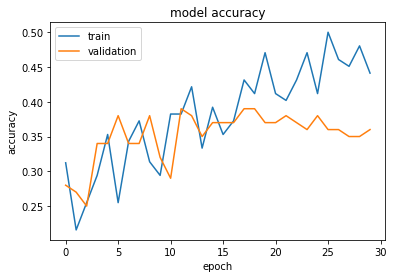

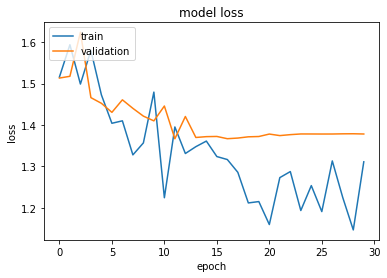

In [51]:
# list all data in history
plot2(history_24)

Note: the depth of neural network starting with filters in the range [8,16,32, 64, 128] in the earlier and increasing up to [256, 512, 1024] in the deeper layers.

# Experiment 4e
# conv2D with batch_size =30 and num_epochs=20
# conv2D+LSTM
# input has  3 x 3 filter
# following layers have 3 x 3 filter
# number of filters 256 in each
#Conv2D +LSTM
#lr =.001
#TimeDistributed Conv2D->TimeDIstributed MaxPooling2D->
#TimeDistributed Flatten->LSTM(256)->LSTM(256)->LSTM(256)->Flatten->Softmax

In [52]:
#Model-- model25
# conv2D with stacked LSTM - 3 hidden layers

num_epochs = 30
batch_size = 20

input_shape = (30,120,120,3)

model25 = Sequential()
# define CNN model,
# stride (2,2) to reduce output volume, default (1,1)
model25.add(TimeDistributed(Conv2D(256, (3, 3),strides=(2, 2),  input_shape=input_shape, activation='relu')))
model25.add(TimeDistributed(MaxPooling2D(pool_size = (2, 2))))
model25.add(TimeDistributed(Flatten()))
# define stacked LSTM model - 3 hidden layers
model25.add(LSTM(256, return_sequences=True))
model25.add(LSTM(256, return_sequences=True))
model25.add(LSTM(256, return_sequences=True))
model25.add(Flatten())
model25.add(Dense(5, activation='softmax'))
model25.build((None,) + input_shape)



optimiser25 = optimizers.Adam(lr=0.001) #write your optimizer
model25.compile(optimizer=optimiser25, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model25.summary())


#************************
train_generator25 = generator(train_path, train_doc, batch_size)
val_generator25 = generator(val_path, val_doc, batch_size)

#*************************
curr_dt_time = datetime.datetime.now()
model_name25 = 'model25_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name25):
    os.mkdir(model_name25)
        
filepath = model_name25 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR25 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR25]

#**************************
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_59 (TimeDis (None, 30, 59, 59, 256)   7168      
_________________________________________________________________
time_distributed_60 (TimeDis (None, 30, 29, 29, 256)   0         
_________________________________________________________________
time_distributed_61 (TimeDis (None, 30, 215296)        0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 30, 256)           220726272 
_________________________________________________________________
lstm_35 (LSTM)               (None, 30, 256)           525312    
_________________________________________________________________
lstm_36 (LSTM)               (None, 30, 256)           525312    
_________________________________________________________________
flatten_25 (Flatten)         (None, 7680)              0         
__________

In [53]:
#***************************
history_25 = model25.fit_generator(train_generator25, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator25,
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 786s 23s/step - loss: 1.6340 - categorical_accuracy: 0.2664 - val_loss: 1.8571 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model25_init_2020-06-2817_37_54.164147/model-00001-1.64542-0.25641-1.85709-0.19000.h5
Epoch 2/30
34/34 [==============================] - 609s 18s/step - loss: 1.5858 - categorical_accuracy: 0.2549 - val_loss: 1.5983 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model25_init_2020-06-2817_37_54.164147/model-00002-1.58584-0.25490-1.59826-0.23000.h5
Epoch 3/30
34/34 [==============================] - 598s 18s/step - loss: 1.5438 - categorical_accuracy: 0.3137 - val_loss: 1.6810 - val_categorical_accuracy: 0.1700

Epoch 00003: saving model to model25_init

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


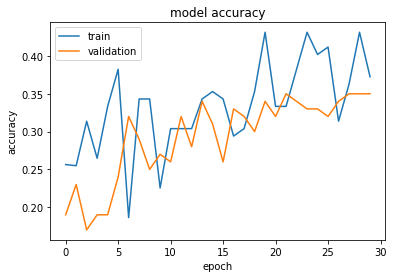

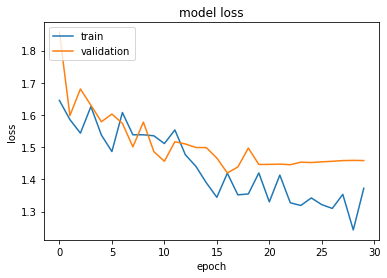

In [54]:
# list all data in history
plot2(history_25)

# Experiment 4f
# conv2D with batch_size =20 and num_epochs=20
#Conv2D 
#lr =.001
#TimeDistributed Conv2D->TimeDIstributed MaxPooling2D->
#TimeDistributed Conv2D->TimeDIstributed MaxPooling2D->
#TimeDistributed Conv2D->TimeDIstributed MaxPooling2D->
#Flatten->Softmax
# stride =1
# without BN, DropOut and LSTM

In [3]:
# train_doc = np.random.permutation(open('./train.csv').readlines())
# val_doc = np.random.permutation(open('./val.csv').readlines())
train_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val.csv').readlines())
input_shape = (30,120,120,3)
batch_size = 20
num_epochs = 20
x=30
y=120
z=120

In [4]:

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:140] 
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                    #print(t_image.shape)
                    
                 
                    #print(t_image[0].shape)
                    #print(t_image[1].shape)
                    #print(t_image[2].shape)
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:120] 
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [5]:
# curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [7]:
model26 = Sequential()
# input layer
model26.add(TimeDistributed(Conv2D(filters=128, kernel_size=3,  strides=1, input_shape=input_shape,activation='relu')))
model26.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)))
#layer 1
model26.add(TimeDistributed(Conv2D(filters=256, kernel_size=3, strides=1, activation='relu')))
model26.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)))
# layer 2
model26.add(TimeDistributed(Conv2D(filters=256, kernel_size=3, strides=1, activation='relu')))
model26.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)))
model26.add(Flatten())
# output layer
model26.add(Dense(5, activation='softmax'))
model26.build((None,) + input_shape)


Instructions for updating:
Colocations handled automatically by placer.


In [8]:

optimiser26 = optimizers.Adam(lr=0.001) #write your optimizer
model26.compile(optimizer=optimiser26, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model26.summary())


#************************
train_generator26 = generator(train_path, train_doc, batch_size)
val_generator26 = generator(val_path, val_doc, batch_size)

#*************************
curr_dt_time = datetime.datetime.now()
model_name26 = 'model26_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name26):
    os.mkdir(model_name26)
        
filepath = model_name26 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR26 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR26]

#**************************
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 118, 118, 128) 3584      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 59, 59, 128)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 57, 57, 256)   295168    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 28, 28, 256)   0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 26, 26, 256)   590080    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 13, 13, 256)   0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1297920)           0         
__________

In [9]:
#***************************
history_26 = model26.fit_generator(train_generator26, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator26,
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 941s 28s/step - loss: 12.5599 - categorical_accuracy: 0.2016 - val_loss: 12.4109 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model26_init_2020-06-2912_45_29.793036/model-00001-12.47139-0.20664-12.41093-0.23000.h5
Epoch 2/20
34/34 [==============================] - 170s 5s/step - loss: 12.4836 - categorical_accuracy: 0.2255 - val_loss: 12.4109 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model26_init_2020-06-2912_45_29.793036/model-00002-12.48362-0.22549-12.41093-0.23000.h5
Epoch 3/20
34/34 [==============================] - 172s 5s/step - loss: 12.7997 - categorical_accuracy: 0.2059 - val_loss: 12.4109 - val_categorical_acc

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


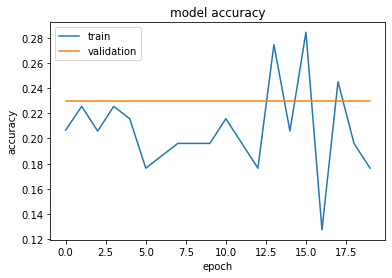

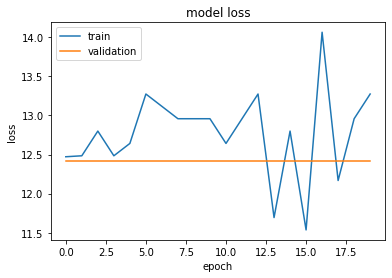

In [12]:

plot2(history_26)

# EXPERIMENT 4g Conv2D +RNN
# with batch normalization
# Model 2 conv2D + LSTM

There’s some debate as to whether the dropout should be placed before or after the activation function. 
As a rule of thumb, place the dropout after the activate function for all activation functions other than relu. 
In passing 0.5, every hidden unit (neuron) is set to 0 with a probability of 0.5. 
In other words, there’s a 50% change that the output of a given neuron will be forced to 0.

In [35]:
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.regularizers import l2
from keras.layers.recurrent import LSTM
from keras.layers.normalization import BatchNormalization
batch_size  = 30
num_epochs = 15
y = 120
z = 120
nb_channel = 3
# Input_shape =(30,y,z,3)
nb_classes  = 5

In [30]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:140] #cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) #skimage.transform.resize(image,(120,120))  
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                    #print(t_image.shape)
                    
                 
                    #print(t_image[0].shape)
                    #print(t_image[1].shape)
                    #print(t_image[2].shape)
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:140] #cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) #skimage.transform.resize(image,(120,120))  
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [37]:
train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
print ('# epochs =', num_epochs)
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 15
# batch size = 30


# lr= .0002
# filter size = (3,3)
# batch_size =30, epochs=15
#conv2D ->BN->MaxPooling2D-> conv2D ->BN->MaxPooling2D
#conv2D ->BN->MaxPooling2Dconv2D ->BN->MaxPooling2D
#-> flatten->LSTM(1024)->Dense->Droupout(0.25)-> Dense(softmax)->dropout(0.25)

In [38]:
model_4g = Sequential()

model_4g.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),input_shape=(x,y,z,nb_channel)))
model_4g.add(TimeDistributed(BatchNormalization()))
model_4g.add(TimeDistributed(MaxPooling2D((2,2))))

model_4g.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model_4g.add(TimeDistributed(BatchNormalization()))
model_4g.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4g.add(TimeDistributed(Conv2D(64, (3, 3),padding='same', activation='relu')))
model_4g.add(TimeDistributed(BatchNormalization()))
model_4g.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4g.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation='relu')))
model_4g.add(TimeDistributed(BatchNormalization()))
model_4g.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4g.add(TimeDistributed(Conv2D(256, (3, 3), padding='same',activation='relu')))
model_4g.add(TimeDistributed(BatchNormalization()))
model_4g.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4g.add(TimeDistributed(Flatten()))
model_4g.add(LSTM(1024))

model_4g.add(Dense(512,activation='relu'))
model_4g.add(Dropout(0.25))

model_4g.add(Dense(5, activation='softmax'))
model_4g.add(Dropout(0.25))

train_generator4g= generator(train_path, train_doc, batch_size)
val_generator4g = generator( val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0002) #write your optimizer
model_4g.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_4g.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_50 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_51 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_53 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_54 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 30, 30, 30, 64)    18496     
__________

In [39]:
validation_steps,steps_per_epoch,callbacks_list= model_init('model4g_init',num_train_sequences,batch_size,num_val_sequences)

In [40]:
history_4g = model_4g.fit_generator(train_generator4g, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator4g, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 30
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 30
23/23 [==============================] - 504s 22s/step - loss: nan - categorical_accuracy: 0.3130 - val_loss: nan - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model4g_init_2020-06-3013_15_56.598724/model-00001-nan-0.31222-nan-0.16000.h5
Epoch 2/15
23/23 [==============================] - 71s 3s/step - loss: nan - categorical_accuracy: 0.2319 - val_loss: nan - val_categorical_accuracy: 0.1750

Epoch 00002: saving model to model4g_init_2020-06-3013_15_56.598724/model-00002-nan-0.23188-nan-0.17500.h5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 3/15
23/23 [==============================] - 72s 3s/step - loss: nan - categorical_accuracy: 0.2029 - val_loss: nan - val_categorical_accuracy: 0.1250

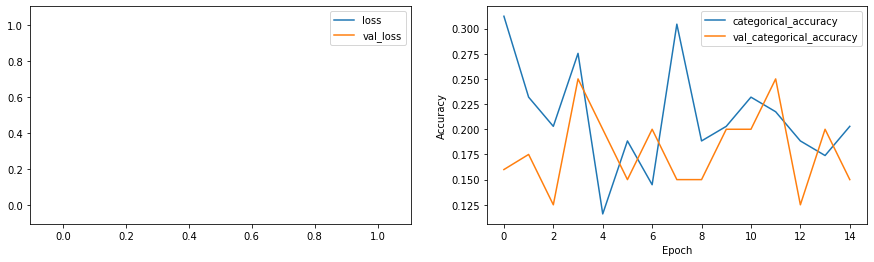

In [43]:
plot(history_4g)

# Experiment 4g1 
# Conv2D +RNN
# with batch normalization
# Model 2 conv2D + LSTM
# Batch 30, epochs =15
# softmax without dropout
# lr default learning rate 
# filter size = (3,3)
#TimeDistributedconv2D ->TimeDistributedBN->TimeDistributedMaxPooling2D-> 
#TimeDistributedconv2D ->TimeDistributedBN->TimeDistributedMaxPooling2D->
#TimeDistributedconv2D ->TimeDistributedBN->TimeDistributedMaxPooling2D->
#TimeDistributedconv2D ->TimeDistributedBN->TimeDistributedMaxPooling2D
#->flatten->LSTM(1024)->Dense->Droupout(0.25)-> Dense(softmax)

In [31]:
batch_size= 30
num_epochs =15
x = 30
y = 120
z = 120
nb_channel = 3
# Input_shape =(30,y,z,3)
nb_classes  = 5
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
print ('# epochs =', num_epochs)
print ('# batch size =', batch_size)

# model
model_4g1 = Sequential()

model_4g1.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),input_shape=(x,y,z,nb_channel)))
model_4g1.add(TimeDistributed(BatchNormalization()))
model_4g1.add(TimeDistributed(MaxPooling2D((2,2))))

model_4g1.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model_4g1.add(TimeDistributed(BatchNormalization()))
model_4g1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4g1.add(TimeDistributed(Conv2D(64, (3, 3),padding='same', activation='relu')))
model_4g1.add(TimeDistributed(BatchNormalization()))
model_4g1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4g1.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation='relu')))
model_4g1.add(TimeDistributed(BatchNormalization()))
model_4g1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4g1.add(TimeDistributed(Conv2D(256, (3, 3), padding='same',activation='relu')))
model_4g1.add(TimeDistributed(BatchNormalization()))
model_4g1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4g1.add(TimeDistributed(Flatten()))
model_4g1.add(LSTM(1024))

model_4g1.add(Dense(512,activation='relu'))
model_4g1.add(Dropout(0.25))

model_4g1.add(Dense(5, activation='softmax'))


train_generator4g1= generator(train_path, train_doc, batch_size)
val_generator4g1 = generator( val_path, val_doc, batch_size)

optimiser = optimizers.Adam() #write your optimizer
model_4g1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_4g1.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 15
# batch size = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_34 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_35 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 30, 30, 30, 32)    0         
______________________________________________________

In [32]:
validation_steps,steps_per_epoch,callbacks_list = model_init('model4g1_init',num_train_sequences,batch_size,num_val_sequences)

In [33]:
history_4g1 = model_4g1.fit_generator(train_generator4g1, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator4g1, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 30
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 30
23/23 [==============================] - 502s 22s/step - loss: 1.3483 - categorical_accuracy: 0.4756 - val_loss: 1.2070 - val_categorical_accuracy: 0.5600

Epoch 00001: saving model to model4g1_init_2020-06-3016_23_21.921567/model-00001-1.35003-0.48115-1.20696-0.56000.h5
Epoch 2/15
23/23 [==============================] - 72s 3s/step - loss: 1.5059 - categorical_accuracy: 0.3478 - val_loss: 1.3164 - val_categorical_accuracy: 0.4750

Epoch 00002: saving model to model4g1_init_2020-06-3016_23_21.921567/model-00002-1.50588-0.34783-1.31637-0.47500.h5
Epoch 3/15
23/23 [==============================] - 71s 3s/step - loss: 1.3795 - categorical_accuracy: 0.4493 - val_loss: 1.4600 - val_categorical_accuracy: 0.3750

Epoch 00003: saving model to model4g1_init_

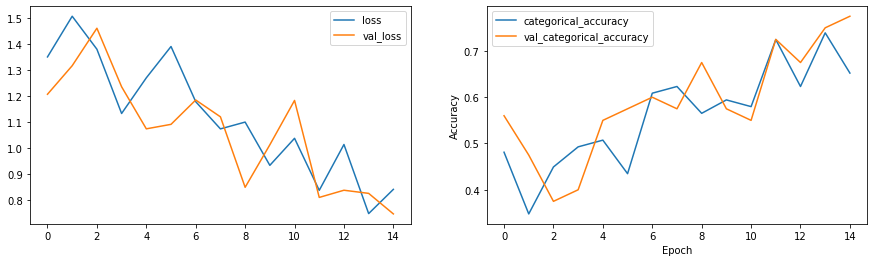

In [34]:
plot(history_4g1)

# Experiment 4h 
# Conv2D +RNN
# with batch normalization
# Model 2 conv2D + LSTM
# Batch 10, epochs =20
# lr= .0002
# filter size = (3,3)
#conv2D ->BN->MaxPooling2D-> conv2D ->BN->MaxPooling2D
#conv2D ->BN->MaxPooling2Dconv2D ->BN->MaxPooling2D
#-> flatten->LSTM(1024)->Dense->Droupout(0.25)-> Dense(softmax)

In [50]:
batch_size  = 10
num_epochs = 20
x = 30
y = 120
z = 120
nb_channel = 3
# Input_shape =(30,y,z,3)
nb_classes  = 5

train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
print ('# epochs =', num_epochs)
print ('# batch size =', batch_size)

model_4h = Sequential()

model_4h.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),input_shape=(x,y,z,nb_channel)))
model_4h.add(TimeDistributed(BatchNormalization()))
model_4h.add(TimeDistributed(MaxPooling2D((2,2))))

model_4h.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model_4h.add(TimeDistributed(BatchNormalization()))
model_4h.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4h.add(TimeDistributed(Conv2D(64, (3, 3),padding='same', activation='relu')))
model_4h.add(TimeDistributed(BatchNormalization()))
model_4h.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4h.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation='relu')))
model_4h.add(TimeDistributed(BatchNormalization()))
model_4h.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4h.add(TimeDistributed(Conv2D(256, (3, 3), padding='same',activation='relu')))
model_4h.add(TimeDistributed(BatchNormalization()))
model_4h.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4h.add(TimeDistributed(Flatten()))
model_4h.add(LSTM(1024))

model_4h.add(Dense(512,activation='relu'))
model_4h.add(Dropout(0.25))

model_4h.add(Dense(5, activation='softmax'))
#model_4h.add(Dropout(0.25))

train_generator4h= generator(train_path, train_doc, batch_size)
val_generator4h = generator( val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0002) #write your optimizer
model_4h.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_4h.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_81 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_82 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_83 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_84 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_85 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_86 (TimeDis (None, 30, 30, 30, 32)    0         
______________________________________________________

In [51]:
validation_steps,steps_per_epoch,callbacks_list = model_init('model4h_init',num_train_sequences,batch_size,num_val_sequences)

In [52]:
history_4h = model_4h.fit_generator(train_generator4h, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator4h, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 10
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 10
67/67 [==============================] - 523s 8s/step - loss: 1.2351 - categorical_accuracy: 0.4796 - val_loss: 0.8307 - val_categorical_accuracy: 0.6900

Epoch 00001: saving model to model4h_init_2020-06-3013_48_40.149145/model-00001-1.23443-0.48115-0.83069-0.69000.h5
Epoch 2/20
67/67 [==============================] - 202s 3s/step - loss: 0.9984 - categorical_accuracy: 0.5970 - val_loss: 1.0516 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model4h_init_2020-06-3013_48_40.149145/model-00002-0.99843-0.59701-1.05155-0.59000.h5
Epoch 3/20
67/67 [==============================] - 201s 3s/step - loss: 1.0370 - categorical_accuracy: 0.6318 - val_loss: 0.9879 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model4h_init_20

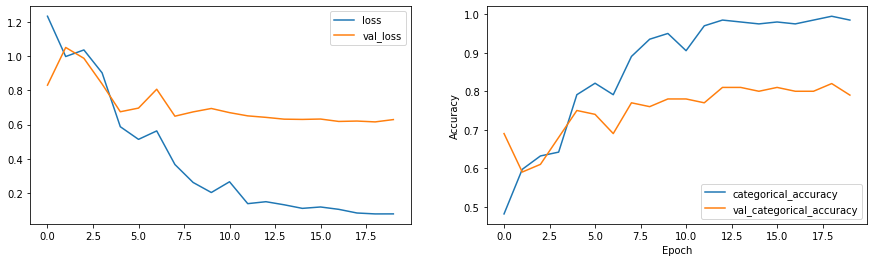

In [53]:
plot(history_4h)

# Experiment 4i conv2d +GRU with BatchNormalization
# lr= Adam optimizer default learning rate ,i.e., 0.001
# filter size = (3,3)
#batch_size  = 30
#num_epochs = 15
#conv2D ->BN->MaxPooling2D-> conv2D ->BN->MaxPooling2D
#conv2D ->BN->MaxPooling2Dconv2D ->BN->MaxPooling2D-> 
#flatten->GRU(1024)->Dense->Droupout(0.25)-> Dense(softmax))
# image size= (120,120)

In [35]:
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.regularizers import l2
from keras.layers.recurrent import GRU
from keras.layers.normalization import BatchNormalization


In [36]:
batch_size  = 30
num_epochs = 15
y = 120
z = 120
nb_channel = 3
# Input_shape =(30,y,z,3)
nb_classes  = 5

model_4i = Sequential()

model_4i.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),input_shape=(x,y,z,nb_channel)))
model_4i.add(TimeDistributed(BatchNormalization()))
model_4i.add(TimeDistributed(MaxPooling2D((2,2))))

model_4i.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model_4i.add(TimeDistributed(BatchNormalization()))
model_4i.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4i.add(TimeDistributed(Conv2D(64, (3, 3),padding='same', activation='relu')))
model_4i.add(TimeDistributed(BatchNormalization()))
model_4i.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4i.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation='relu')))
model_4i.add(TimeDistributed(BatchNormalization()))
model_4i.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4i.add(TimeDistributed(Conv2D(256, (3, 3), padding='same',activation='relu')))
model_4i.add(TimeDistributed(BatchNormalization()))
model_4i.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4i.add(TimeDistributed(Flatten()))
model_4i.add(GRU(1024))

model_4i.add(Dense(512,activation='relu'))
model_4i.add(Dropout(0.25))

model_4i.add(Dense(5, activation='softmax'))


train_generator4i= generator(train_path, train_doc, batch_size)
val_generator4i = generator( val_path, val_doc, batch_size)

optimiser = optimizers.Adam() #write your optimizer
model_4i.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_4i.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_50 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_51 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_53 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_54 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 30, 30, 30, 64)    18496     
__________

In [37]:
validation_steps,steps_per_epoch,callbacks_list = model_init('model4i_init',num_train_sequences,batch_size,num_val_sequences)

In [38]:
history_4i = model_4i.fit_generator(train_generator4i, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator4i, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 30
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 30
23/23 [==============================] - 503s 22s/step - loss: 1.5174 - categorical_accuracy: 0.5113 - val_loss: 1.0664 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model4i_init_2020-06-3016_48_31.492356/model-00001-1.55859-0.50528-1.06641-0.53000.h5
Epoch 2/15
23/23 [==============================] - 66s 3s/step - loss: 1.9014 - categorical_accuracy: 0.3913 - val_loss: 1.5575 - val_categorical_accuracy: 0.3250

Epoch 00002: saving model to model4i_init_2020-06-3016_48_31.492356/model-00002-1.90136-0.39130-1.55748-0.32500.h5
Epoch 3/15
23/23 [==============================] - 66s 3s/step - loss: 1.7797 - categorical_accuracy: 0.3333 - val_loss: 1.5943 - val_categorical_accuracy: 0.3500

Epoch 00003: saving model to model4i_init_202

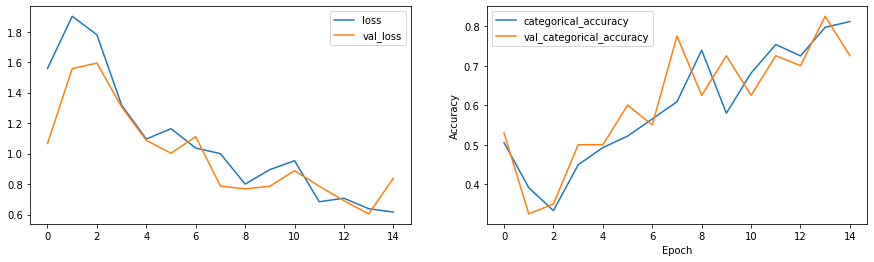

In [39]:
plot(history_4i)

# Experiment 4j 
# conv2d +GRU with BatchNormalization
# lr= Default
# filter size = (3,3)
#batch_size  = 10
#num_epochs = 20
#conv2D ->BN->MaxPooling2D-> conv2D ->BN->MaxPooling2D
#conv2D ->BN->MaxPooling2Dconv2D ->BN->MaxPooling2D
#-> flatten->GRU(1024)->Dense->Droupout(0.25)-> Dense(softmax))
# image size= (120,120)

In [40]:
train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Fin
batch_size  = 10
num_epochs = 20
y = 120
z = 120
nb_channel = 3
# Input_shape =(30,y,z,3)
nb_classes  = 5
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
print ('# epochs =', num_epochs)
print ('# batch size =', batch_size)

model_4j = Sequential()

model_4j.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),input_shape=(x,y,z,nb_channel)))
model_4j.add(TimeDistributed(BatchNormalization()))
model_4j.add(TimeDistributed(MaxPooling2D((2,2))))

model_4j.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model_4j.add(TimeDistributed(BatchNormalization()))
model_4j.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4j.add(TimeDistributed(Conv2D(64, (3, 3),padding='same', activation='relu')))
model_4j.add(TimeDistributed(BatchNormalization()))
model_4j.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4j.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation='relu')))
model_4j.add(TimeDistributed(BatchNormalization()))
model_4j.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4j.add(TimeDistributed(Conv2D(256, (3, 3), padding='same',activation='relu')))
model_4j.add(TimeDistributed(BatchNormalization()))
model_4j.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4j.add(TimeDistributed(Flatten()))
model_4j.add(GRU(1024))

model_4j.add(Dense(512,activation='relu'))
model_4j.add(Dropout(0.25))

model_4j.add(Dense(5, activation='softmax'))


train_generator4j= generator(train_path, train_doc, batch_size)
val_generator4j = generator( val_path, val_doc, batch_size)

optimiser = optimizers.Adam() #write your optimizer
model_4j.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_4j.summary())

validation_steps,steps_per_epoch,callbacks_list = model_init('model4j_init',num_train_sequences,batch_size,num_val_sequences)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_65 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_66 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_67 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_68 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_69 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_70 (TimeDis (None, 30, 30, 30, 32)    0         
______________________________________________________

In [41]:
history_4j = model_4j.fit_generator(train_generator4j, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator4j, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 10
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 10
67/67 [==============================] - 519s 8s/step - loss: 1.6284 - categorical_accuracy: 0.4681 - val_loss: 0.9793 - val_categorical_accuracy: 0.6200

Epoch 00001: saving model to model4j_init_2020-06-3017_12_32.933975/model-00001-1.63936-0.46606-0.97928-0.62000.h5
Epoch 2/20
67/67 [==============================] - 190s 3s/step - loss: 1.3055 - categorical_accuracy: 0.5522 - val_loss: 1.5090 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model4j_init_2020-06-3017_12_32.933975/model-00002-1.30550-0.55224-1.50897-0.53000.h5
Epoch 3/20
67/67 [==============================] - 186s 3s/step - loss: 1.3908 - categorical_accuracy: 0.5124 - val_loss: 1.2678 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model4j_init_20

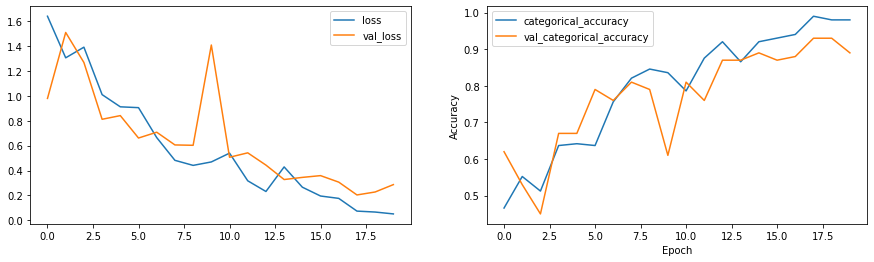

In [42]:
plot(history_4j)

# Experiment 5
# conv2D with batch_size =20 and num_epochs=20
# conv2D+GRU
# input has  7 x 7 filter
# Conv2D following layers have 3 x 3 filter
# a GRU layer for  feature extraction followed by output layer
# stride =(2,2)to reduce the size of the output volume
#lr =.001

In [26]:
# Model 3 conv2D + GRU

from keras.layers.recurrent import GRU
#input_shape=(nb_frames,width,height,nb_channel)
batch_size = 20
epochs     = 20
# the input of the model is a set of images/frames. So the input shape (i.e. one sample's shape) is:
#input_shape=(nb_frames,width,height,nb_channel)
input_shape =(30,120,120,3)
nb_classes  = 5

model3 = Sequential()
model3.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
# layer 1
model3.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
# layer 2
model3.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model3.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
# layer 3
model3.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model3.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
# layer 4
model3.add(TimeDistributed(Conv2D(256, (3,3),padding='same', activation='relu')))
model3.add(TimeDistributed(Conv2D(256, (3,3),padding='same', activation='relu')))
model3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# flatten
model3.add(TimeDistributed(Flatten()))
model3.add(Dropout(0.5))
# GRU layer
model3.add(GRU(256, return_sequences=False, dropout=0.5))
# last layer
model3.add(Dense(nb_classes, activation='softmax'))

In [27]:
optimiser3 = optimizers.Adam(lr=0.001) #write your optimizer
model3.compile(optimizer=optimiser3, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 30, 60, 60, 32)    4736      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 58, 58, 32)    9248      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 29, 29, 64)    18496     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 29, 29, 64)    36928     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 14, 14, 64)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 14, 14, 128)  

In [28]:
#
batch_size = 20
epochs =20
train_generator3 = generator(train_path, train_doc, batch_size)
val_generator3 = generator(val_path, val_doc, batch_size)

In [29]:
#
curr_dt_time = datetime.datetime.now()
model_name3 = 'model3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name3):
    os.mkdir(model_name3)
        
filepath = model_name3 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR3 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR3]

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1 


In [31]:
model3.fit_generator(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 1262s 37s/step - loss: 1.6196 - categorical_accuracy: 0.1855 - val_loss: 1.6070 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model3_init_2020-06-2416_24_14.584686/model-00001-1.62041-0.18552-1.60697-0.16000.h5
Epoch 2/20
34/34 [==============================] - 225s 7s/step - loss: 1.6203 - categorical_accuracy: 0.1961 - val_loss: 1.6205 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model3_init_2020-06-2416_24_14.584686/model-00002-1.62034-0.19608-1.62045-0.18000.h5
Epoch 3/20
34/34 [==============================] - 238s 7s/step - loss: 1.6192 - categorical_accuracy: 0.1471 - val_loss: 1.6015 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model3_init_2020-06

#lr = .0001
# Tranfer learning with mobilenet with GRU and output layer
# Experiment 5a
# batch_size =20
# num_epochs= 10
# Reduce image size  80 X 80 

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize
import datetime
import os
from skimage import io
import imageio
import skimage
import random
import cv2

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)#tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
# train_doc = np.random.permutation(open('./train.csv').readlines())
# val_doc = np.random.permutation(open('./val.csv').readlines())
train_doc = np.random.permutation(open('C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val.csv').readlines())
# batch_size = 10 #experiment with the batch size
batch_size =20
num_epochs= 10

In [4]:
# Parameters initialization
# MobileNet
nb_classes =5
# Reduce image size  80 X 80 instead of 120 X 120
x = 30   # no. of images of the image frames
y = 80  # width y dimesnion of the image 
z = 80  # height z of the video 
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:80, 20:100] 
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (80,80),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                    #print(t_image.shape)
                    
                 
                    #print(t_image[0].shape)
                    #print(t_image[1].shape)
                    #print(t_image[2].shape)
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:80, 20:100] 
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (80,80),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [7]:
#import required libraries
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.layers.recurrent import GRU
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv2D,MaxPooling2D
# from keras.regularizers import l2

In [14]:
#write your model here
from keras.layers import Input
input_tensor1 = Input(shape =(224,224,3))
from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False,input_tensor = input_tensor1)


In [15]:
# y=80, z=80
y= 80
z= 80
model4 = Sequential()
model4.add(TimeDistributed(pretrained_mobilenet,input_shape=(30,y,z,3)))

model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
model4.add(TimeDistributed(Flatten()))

model4.add(GRU(128))
model4.add(Dropout(0.25))

model4.add(Dense(128,activation='relu'))
model4.add(Dropout(0.25))

model4.add(Dense(5, activation='softmax'))

In [16]:
train_generator4 = generator(train_path, train_doc, batch_size)
val_generator4 = generator(val_path, val_doc, batch_size)

optimiser4 = optimizers.Adam(lr=0.0001) #write your optimizer
model4.compile(optimizer=optimiser4, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 30, 2, 2, 1024)    3228864   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 2, 2, 1024)    4096      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [17]:
#
curr_dt_time = datetime.datetime.now()
model_name4 = 'model4_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name4):
    os.mkdir(model_name4)
        
filepath = model_name4 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR4 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR4]

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1 


In [19]:
model4.fit_generator(train_generator4, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator4, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 2129s 63s/step - loss: 1.6203 - categorical_accuracy: 0.2730 - val_loss: 1.3311 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model4_init_2020-06-2515_26_42.992574/model-00001-1.63049-0.27300-1.33107-0.44000.h5
Epoch 2/10
34/34 [==============================] - 366s 11s/step - loss: 1.2104 - categorical_accuracy: 0.5000 - val_loss: 1.0748 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model4_init_2020-06-2515_26_42.992574/model-00002-1.21044-0.50000-1.07476-0.54000.h5
Epoch 3/10
34/34 [==============================] - 361s 11s/step - loss: 1.2627 - categorical_accuracy: 0.5098 - val_loss: 1.2036 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model4_init_2020-

# Tranfer learning with mobilenet with GRU and output layer
# Experiment 5b
# batch_size =20
# num_epochs= 20
# Reduce image size  80 X 80
#lr=.0001

In [20]:
# batch_size = 20 
#experiment with the batch size and number of epochs
# model41
from keras.applications import mobilenet
pretrained_mobilenet41 = mobilenet.MobileNet(weights='imagenet', include_top=False)
batch_size =20
num_epochs= 20
y=80
z=80
model41 = Sequential()
model41.add(TimeDistributed(pretrained_mobilenet41,input_shape=(30,y,z,3)))

model41.add(TimeDistributed(BatchNormalization()))
model41.add(TimeDistributed(MaxPooling2D((2, 2))))
model41.add(TimeDistributed(Flatten()))

model41.add(GRU(128))
model41.add(Dropout(0.25))

model41.add(Dense(128,activation='relu'))
model41.add(Dropout(0.25))

model41.add(Dense(5, activation='softmax'))

In [21]:
train_generator41 = generator(train_path, train_doc, batch_size)
val_generator41 = generator(val_path, val_doc, batch_size)

optimiser41 = optimizers.Adam(lr=0.0001) #write your optimizer
model41.compile(optimizer=optimiser41, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model41.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 30, 2, 2, 1024)    3228864   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 30, 2, 2, 1024)    4096      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [22]:
#
curr_dt_time = datetime.datetime.now()
model_name41 = 'model41_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name41):
    os.mkdir(model_name41)
        
filepath = model_name41 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR41 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list41 = [checkpoint, LR41]

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1 

In [24]:
history41=model41.fit_generator(train_generator41, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list41, validation_data=val_generator41, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path = Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val; batch size = 20
 ; batch size = 20
34/34 [==============================] - 2259s 66s/step - loss: 1.6796 - categorical_accuracy: 0.2881 - val_loss: 1.4228 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model41_init_2020-06-2516_58_27.101062/model-00001-1.68933-0.28808-1.42275-0.41000.h5
Epoch 2/20
34/34 [==============================] - 378s 11s/step - loss: 1.4024 - categorical_accuracy: 0.3725 - val_loss: 1.1253 - val_categorical_accuracy: 0.5100

Epoch 00002: saving model to model41_init_2020-06-2516_58_27.101062/model-00002-1.40241-0.37255-1.12529-0.51000.h5
Epoch 3/20
34/34 [==============================] - 383s 11s/step - loss: 1.3093 - categorical_accuracy: 0.4706 - val_loss: 1.1559 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model41_init_20

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


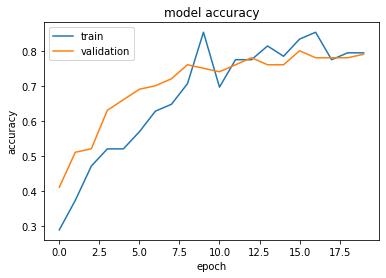

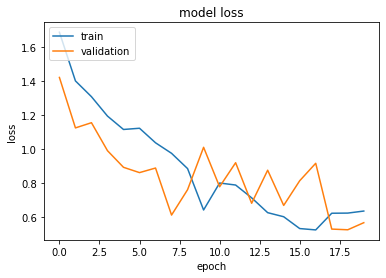

In [25]:
# list all data in history
import matplotlib.pyplot as plt
plot2(history41)

# Tranfer learning with mobilenet with GRU and output layer
# Experiment 5c
# batch_size =20
# num_epochs= 20
# image size  120 X 120
#lr=.001

In [19]:
tf.set_random_seed(30)#tf.random.set_seed(30)

In [20]:
#write your model here
from keras.layers import Input
input_tensor1 = Input(shape =(224,224,3))
from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False,input_tensor = input_tensor1)

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 6s 0us/step


In [21]:
train_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val.csv').readlines())
# batch_size = 20 #experiment with the batch size
batch_size =20
num_epochs= 20

In [22]:
# Parameters initialization
# vgg_16
nb_classes =5
# image size 120 X 120
x = 30   # no. of images of the image frames
y = 120  # width y dimesnion of the image 
z = 120  # height z of the video 
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

In [23]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:140] 
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                    #print(t_image.shape)
                    
                 
                    #print(t_image[0].shape)
                    #print(t_image[1].shape)
                    #print(t_image[2].shape)
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:120] 
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [24]:
# curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [25]:
from keras.applications import mobilenet
pretrained_mobilenet42 = mobilenet.MobileNet(weights='imagenet', include_top=False)
batch_size =20
num_epochs= 20
y=120
z=120
model42 = Sequential()
model42.add(TimeDistributed(pretrained_mobilenet42,input_shape=(30,y,z,3)))

model42.add(TimeDistributed(BatchNormalization()))
model42.add(TimeDistributed(MaxPooling2D((2, 2))))
model42.add(TimeDistributed(Flatten()))

model42.add(GRU(128))
model42.add(Dropout(0.25))

model42.add(Dense(128,activation='relu'))
model42.add(Dropout(0.25))

model42.add(Dense(5, activation='softmax'))

In [26]:
train_generator42 = generator(train_path, train_doc, batch_size)
val_generator42 = generator(val_path, val_doc, batch_size)
optimiser42 = optimizers.Adam(lr=0.001) #write your optimizer
model42.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model42.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
__________

In [28]:
curr_dt_time = datetime.datetime.now()
model_name42 = 'model42_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(model_name42)
    
if not os.path.exists(model_name42):
    os.mkdir(model_name42)
        
filepath = model_name42 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR42 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list42= [checkpoint, LR42]

model42_init_2020-06-2712_44_00.383817/


In [29]:
batch_size = 20
num_epochs = 20

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1 

In [30]:
history42=model42.fit_generator(train_generator42, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list42, validation_data=val_generator42, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 1512s 44s/step - loss: 0.8098 - categorical_accuracy: 0.6954 - val_loss: 0.3855 - val_categorical_accuracy: 0.8500

Epoch 00001: saving model to model42_init_2020-06-2712_44_00.383817/model-00001-0.82294-0.68778-0.38554-0.85000.h5
Epoch 2/20
34/34 [==============================] - 205s 6s/step - loss: 0.7513 - categorical_accuracy: 0.7843 - val_loss: 1.0610 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model42_init_2020-06-2712_44_00.383817/model-00002-0.75131-0.78431-1.06103-0.62000.h5
Epoch 3/20
34/34 [==============================] - 205s 6s/step - loss: 0.7693 - categorical_accuracy: 0.7157 - val_loss: 0.6595 - val_categorical_accuracy: 0.7200

Epoch 00003: saving model to model42_init_

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


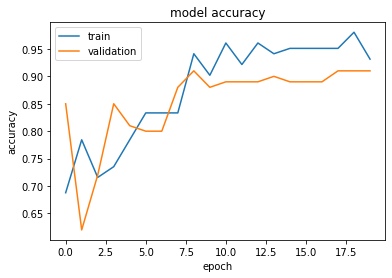

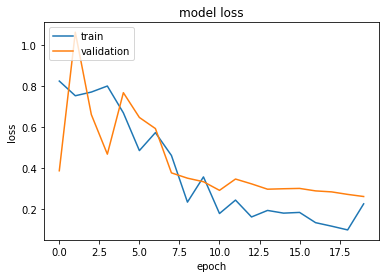

In [31]:
# list all data in history
plot2(history42)


#lr=.0001
# Tranfer learning with VGG16 with LSTM and output layer
# Experiment 6a
# batch_size =20
# num_epochs= 20
# image size  80 X 80

In [1]:
# model5
import numpy as np
import os
# from scipy.misc import imread, imresize
import datetime
import os
from skimage import io
import imageio
import skimage
import random
import cv2
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)#tf.set_random_seed(30)

#
#write your model here
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.layers.recurrent import GRU
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.regularizers import l2

#
from keras.applications.vgg16 import VGG16
from keras.layers import Input
input_tensor1 = Input(shape =(80,80,3))
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
train_doc = np.random.permutation(open('C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val.csv').readlines())
# batch_size = 20 #experiment with the batch size
batch_size =20


In [3]:
# Parameters initialization
# vgg_16
nb_classes =5
# Reduce image size  80 X 80 instead of 120 X 120
x = 30   # no. of images of the image frames
y = 80  # width y dimesnion of the image 
z = 80  # height z of the video 
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:80, 20:100] 
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (80,80),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                    #print(t_image.shape)
                    
                 
                    #print(t_image[0].shape)
                    #print(t_image[1].shape)
                    #print(t_image[2].shape)
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:80, 20:100] 
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (80,80),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [5]:
# curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =10 # wrongly printed
# choose the number of epochs
print ('# epochs =', num_epochs)
# num_epochs = 20 (considered here)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [6]:
vgg_16_model = VGG16(include_top=False, weights='imagenet', input_tensor = input_tensor1)
print(vgg_16_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

In [7]:
input_shape = (30,80,80,3)

# do not train first layers, only train last 4 layers
for layer in vgg_16_model.layers[:-4]:
    layer.trainable = False 

# create a sequential model
model5 = Sequential() 
# add vgg model for 30 frames
model5.add(TimeDistributed(vgg_16_model, input_shape = input_shape))
model5.add(TimeDistributed(Flatten()))
model5.add(LSTM(256,return_sequences = False,activation ='relu'))
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.5))
#softmax layer- 5 outputs
model5.add(Dense(5, activation='softmax'))

In [8]:
train_generator5 = generator(train_path, train_doc, batch_size)
val_generator5 = generator(val_path, val_doc, batch_size)
optimiser5 = optimizers.Adam(lr=0.0001) #write your optimizer
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 2, 2, 512)     14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 2048)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               2360320   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 17,091,781
Trainable params: 9,456,517
Non-trainable params: 7,635,264
___________________________________

In [9]:
#
curr_dt_time = datetime.datetime.now()
model_name5 = 'model5_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(model_name5)
    
if not os.path.exists(model_name5):
    os.mkdir(model_name5)
        
filepath = model_name5 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR5 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list5= [checkpoint, LR5]

model5_init_2020-06-2522_33_49.573170/


In [10]:
batch_size = 20
num_epochs = 20

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1 

In [11]:
history5=model5.fit_generator(train_generator5, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list5, validation_data=val_generator5, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/nvs/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 2350s 69s/step - loss: 2.3514 - categorical_accuracy: 0.2066 - val_loss: 1.6123 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model5_init_2020-06-2522_33_49.573170/model-00001-2.36993-0.20664-1.61228-0.20000.h5
Epoch 2/20
34/34 [==============================] - 567s 17s/step - loss: 1.6296 - categorical_accuracy: 0.2255 - val_loss: 1.6010 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model5_init_2020-06-2522_33_49.573170/model-00002-1.62957-0.22549-1.60095-0.21000.h5
Epoch 3/20
34/34 [==============================] - 579s 17s/step - loss: 1.6132 - categorical_accuracy: 0.1765 - val_loss: 1.6125 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model5_init_2020-

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


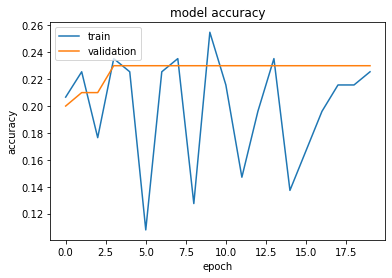

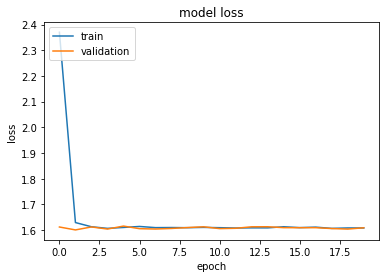

In [12]:
# list all data in history
import matplotlib.pyplot as plt
plot2(history5)

# Tranfer learning with VGG16 with LSTM and output layer
# Experiment 6b
# batch_size =20
# num_epochs= 20
# image size  120 X 120
# default learning rate

In [3]:

# model51
import numpy as np
import os
# from scipy.misc import imread, imresize
import datetime
import os
from skimage import io
import imageio
import skimage
import random
import cv2
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.random.set_seed(30)#
tf.set_random_seed(30)

#
#write your model here
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.layers.recurrent import GRU
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.regularizers import l2

#
from keras.applications.vgg16 import VGG16
from keras.layers import Input
input_tensor1 = Input(shape =(120,120,3))
from keras.layers import LSTM

In [6]:
batch_size = 20
num_epochs = 20 
train_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val.csv').readlines())
# batch_size = 20 #experiment with the batch size


In [7]:
# Parameters initialization
# vgg_16
nb_classes =5
# image size 120 X 120
x = 30   # no. of images of the image frames
y = 120  # width y dimesnion of the image 
z = 120  # height z of the video 
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:120] 
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                    #print(t_image.shape)
                    
                 
                    #print(t_image[0].shape)
                    #print(t_image[1].shape)
                    #print(t_image[2].shape)
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])# normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])# normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])# normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:120] 
                    else:
                        image
                        # This is because cv2 read images in (b,g,r)
                        # (b, g, r) = cv2.split(image)
                        # image     = cv2.merge([r,g,b])
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
                    # print('print resize = {}'.format(image.shape))
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (t_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (t_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [9]:
# curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# num_epochs =10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [10]:
vgg_16_model51 = VGG16(include_top=False, weights='imagenet', input_tensor = input_tensor1)
print(vgg_16_model51.summary())

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 26s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
____

In [11]:
input_shape = (30,120,120,3)

# do not train first layers, only train last 4 layers
for layer in vgg_16_model51.layers[:-4]:
    layer.trainable = False 

# create a sequential model
model51 = Sequential() 
# add vgg model for 30 frames
model51.add(TimeDistributed(vgg_16_model51, input_shape = input_shape))
model51.add(TimeDistributed(Flatten()))
model51.add(LSTM(1024,return_sequences = False,activation ='relu',input_shape=(30,120)))
model51.add(Dense(128, activation='relu'))
model51.add(Dense(64, activation='relu'))
model51.add(Dense(64))
model51.add(Dropout(0.5))
#softmax layer- 5 outputs
model51.add(Dense(5, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
train_generator51 = generator(train_path, train_doc, batch_size)
val_generator51 = generator(val_path, val_doc, batch_size)
# optimiser51 = optimizers.Adam(lr=0.0001) #write your optimizer
model51.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model51.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 4608)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              23072768  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [13]:
#
curr_dt_time = datetime.datetime.now()
model_name51 = 'model51_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(model_name51)
    
if not os.path.exists(model_name51):
    os.mkdir(model_name51)
        
filepath = model_name51 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR51 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list51= [checkpoint, LR51]

model51_init_2020-06-2616_06_25.371812/


In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1 

In [15]:
history51=model51.fit_generator(train_generator51, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list51, validation_data=val_generator51, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 946s 28s/step - loss: 12.7079 - categorical_accuracy: 0.1891 - val_loss: 13.2168 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model51_init_2020-06-2616_06_25.371812/model-00001-12.75670-0.18552-13.21684-0.18000.h5
Epoch 2/20
34/34 [==============================] - 271s 8s/step - loss: 13.1157 - categorical_accuracy: 0.1863 - val_loss: 13.2168 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model51_init_2020-06-2616_06_25.371812/model-00002-13.11570-0.18627-13.21684-0.18000.h5
Epoch 3/20
34/34 [==============================] - 271s 8s/step - loss: 12.0096 - categorical_accuracy: 0.2549 - val_loss: 13.2168 - val_categorical_acc

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


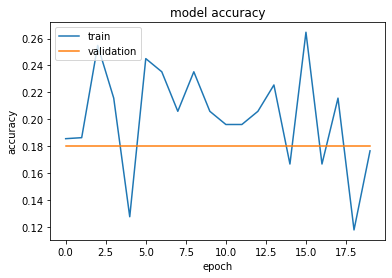

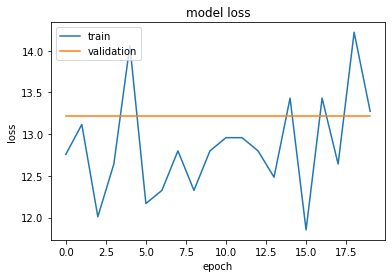

In [18]:
plot2(history51)

# Experiment 7
# conv3D with conversion of BGR to Gray scale images

# batch_size =20
# num_epochs= 20
# image size  120 X 120
#lr=.001

In [1]:
# Gray scale images
import numpy as np
import os
# from scipy.misc import imread, imresize
import datetime
import os
from skimage import io
import imageio
import skimage
import random
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.random.set_seed(30)
# 
tf.set_random_seed(30)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


#write your model here
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.regularizers import l2
from keras.layers.recurrent import LSTM

In [3]:
import cv2
batch_size = 20
num_epochs = 20
x=30
y=120
z=120
nb_channels = 3 # colour image

In [4]:
# train_doc = np.random.permutation(open('./train.csv').readlines())
# val_doc = np.random.permutation(open('./val.csv').readlines())
train_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val.csv').readlines())


In [5]:

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    # Converting color image to grayscale image
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    # Blur it
                    # Gaussian Kernel Size. [height width]. height and width should be odd and can have different values.
                    image = cv2.GaussianBlur(image,(5,5),0)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:140] 
                    else:
                        image

                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
             
                    
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                    # print(t_image.shape)

                    batch_data[folder,idx,:,:,0] = (t_image[:,:])# normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Converting color image to grayscale image
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    # Blur it
                    # Gaussian Kernel Size. [height width]. height and width should be odd and can have different values.
                    image = cv2.GaussianBlur(image,(5,5),0)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:120] 
                    else:
                        image
                       
                        
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) # Reduce image size so training can be faster
                    
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:])

                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [6]:
# curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train'
val_path ='C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val'
#train_path = './train'#'/notebooks/storage/Final_data/Collated_training/train'
#val_path =  './val'#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [10]:
nb_filters = [8,16,32,64]
#nb_dense = [1000, 500, 5]
nb_dense = [256, 128, 5]

# Input
# the input of the model is a set of images/frames. So the input shape (i.e. one sample's shape) is:
#input_shape=(nb_frames,width,height,nb_channel)
input_shape =(30,120,120,3)

# Define model_conv3dGray
model_conv3dGray = Sequential()

# layer 1
model_conv3dGray.add(Conv3D(8, kernel_size=(3,3,3),input_shape=input_shape,padding='same'))
model_conv3dGray.add(BatchNormalization())
model_conv3dGray.add(Activation('relu'))

model_conv3dGray.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 2
model_conv3dGray.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_conv3dGray.add(BatchNormalization())
model_conv3dGray.add(Activation('relu'))

model_conv3dGray.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 3
model_conv3dGray.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model_conv3dGray.add(BatchNormalization())
model_conv3dGray.add(Activation('relu'))

model_conv3dGray.add(MaxPooling3D(pool_size=(2,2,2)))
# layer 4
model_conv3dGray.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model_conv3dGray.add(Activation('relu'))
model_conv3dGray.add(Dropout(0.25))

model_conv3dGray.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_conv3dGray.add(Flatten())

model_conv3dGray.add(Dense(nb_dense[0], activation='relu'))
model_conv3dGray.add(Dropout(0.5))

model_conv3dGray.add(Dense(nb_dense[1], activation='relu'))
model_conv3dGray.add(Dropout(0.5))

#softmax layer
model_conv3dGray.add(Dense(nb_dense[2], activation='softmax'))

In [14]:

optimiserGray = optimizers.Adam(lr=0.001) #write your optimizer
model_conv3dGray.compile(optimizer=optimiserGray, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv3dGray.summary())


#************************
train_generator3dGray = generator(train_path, train_doc, batch_size)
val_generator3dGray = generator(val_path, val_doc, batch_size)

#*************************
curr_dt_time = datetime.datetime.now()
model_name3dG = 'model_conv3dGray_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name3dG):
    os.mkdir(model_name3dG)
        
filepath = model_name3dG + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

#**************************
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [15]:
historyconv3dG=model_conv3dGray.fit_generator(train_generator3dGray, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3dGray, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 526s 15s/step - loss: 1.4117 - categorical_accuracy: 0.3775 - val_loss: 1.4166 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_conv3dGray_init_2020-06-2914_41_51.230379/model-00001-1.40792-0.37858-1.41661-0.37000.h5
Epoch 2/20
34/34 [==============================] - 177s 5s/step - loss: 1.5230 - categorical_accuracy: 0.2941 - val_loss: 1.4135 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_conv3dGray_init_2020-06-2914_41_51.230379/model-00002-1.52298-0.29412-1.41349-0.52000.h5
Epoch 3/20
34/34 [==============================] - 177s 5s/step - loss: 1.3976 - categorical_accuracy: 0.4118 - val_loss: 1.3324 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


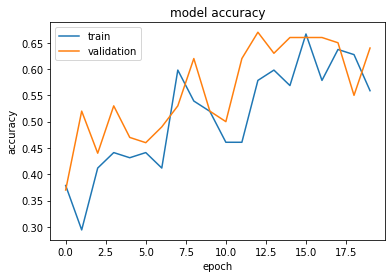

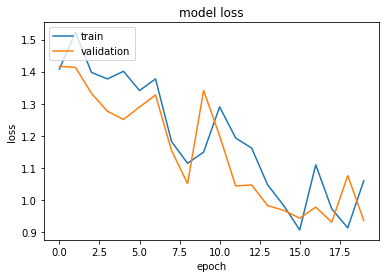

In [29]:
# list all data in history
import matplotlib.pyplot as plt
plot2(historyconv3dG)

# Experiment 8
# Model-- modelCon2dG
# conv2D with stacked LSTM - 3 hidden layers
# For Gray scale images
# conversion of BGR to Gray scale images

# batch_size =20
# num_epochs= 20
# image size  120 X 120
#lr=.001

In [18]:
def generator_Gray(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # number_of_frames
    img_idx = [nf for nf in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted (os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # io.read()imageio
                    # Converting color image to grayscale image
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    # Blur it
                    # Gaussian Kernel Size. [height width]. height and width should be odd and can have different values.
                    image = cv2.GaussianBlur(image,(5,5),0)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:140] 
                    else:
                        image

                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) 
             
                    
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1                    
                    # print(t_image.shape)

                    batch_data[folder,idx,:,:,0] = (t_image[:,:])# normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate oer the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Converting color image to grayscale image
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    # Blur it
                    # Gaussian Kernel Size. [height width]. height and width should be odd and can have different values.
                    image = cv2.GaussianBlur(image,(5,5),0)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # crop
                    
                    if image.shape[0] != image.shape[1]:                        
                        image = image[0:120, 20:120] 
                    else:
                        image
                       
                        
                    # resize
                    image = cv2.resize(image, (120,120),interpolation = cv2.INTER_AREA) # Reduce image size so training can be faster
                    
                    # Normalize
                    # print('Normalize')
                    t_image = image/127.5-1 
                    
                    batch_data[folder,idx,:,:,0] = (t_image[:,:])
                    
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [19]:
#Model-- modelCon2dG
# conv2D with stacked LSTM - 3 hidden layers

num_epochs = 20
batch_size = 20

input_shape = (30,120,120,3)

modelConv2dG = Sequential()
# define CNN model
modelConv2dG.add(TimeDistributed(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu')))
modelConv2dG.add(TimeDistributed(MaxPooling2D(pool_size = (2, 2))))
modelConv2dG.add(TimeDistributed(Flatten()))
# define stacked LSTM model - 3 hidden layers
modelConv2dG.add(LSTM(32, return_sequences=True))
modelConv2dG.add(LSTM(32, return_sequences=True))
modelConv2dG.add(LSTM(32, return_sequences=True))
modelConv2dG.add(Flatten())
modelConv2dG.add(Dense(5, activation='softmax'))
modelConv2dG.build((None,) + input_shape)



optimiser = optimizers.Adam(lr=0.001) #write your optimizer
modelConv2dG.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv2dG.summary())


#************************
train_generator = generator_Gray(train_path, train_doc, batch_size)
val_generator = generator_Gray(val_path, val_doc, batch_size)

#*************************
curr_dt_time = datetime.datetime.now()
model_name = 'modelConv2dG_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

#**************************
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 118, 118, 32)  896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 59, 59, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 111392)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 32)            14262400  
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
flatten_4 (Flatten)          (None, 960)               0         
__________

In [20]:
historyconv2dG=modelConv2dG.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 125s 4s/step - loss: 1.5109 - categorical_accuracy: 0.2708 - val_loss: 1.4960 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to modelConv2dG_init_2020-06-2915_46_37.110316/model-00001-1.51391-0.27753-1.49601-0.28000.h5
Epoch 2/20
34/34 [==============================] - 47s 1s/step - loss: 1.4816 - categorical_accuracy: 0.3529 - val_loss: 1.4456 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to modelConv2dG_init_2020-06-2915_46_37.110316/model-00002-1.48162-0.35294-1.44557-0.29000.h5
Epoch 3/20
34/34 [==============================] - 48s 1s/step - loss: 1.2961 - categorical_accuracy: 0.3627 - val_loss: 1.5797 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to modelCo

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


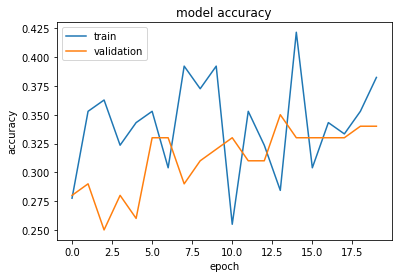

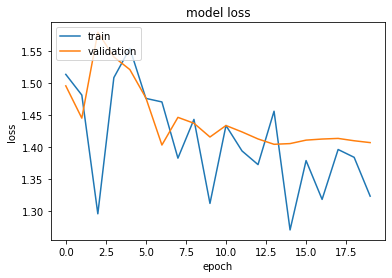

In [21]:
# list all data in history
import matplotlib.pyplot as plt
plot2(historyconv2dG)

# Experiment 9
# Model-- modelCon2dG
# MobileNet with GRU
# For Gray scale images
# conversion of BGR to Gray scale images

# batch_size =20
# num_epochs= 20
# image size  120 X 120
#lr=.001

In [22]:
x=30
y=120
z=120
from keras.applications import mobilenet
pretrained_mobilenet_g = mobilenet.MobileNet(weights='imagenet', include_top=False)
batch_size =20
num_epochs= 20
y=120
z=120
mobilenet_modelG = Sequential()
mobilenet_modelG.add(TimeDistributed(pretrained_mobilenet_g,input_shape=(30,y,z,3)))

mobilenet_modelG.add(TimeDistributed(BatchNormalization()))
mobilenet_modelG.add(TimeDistributed(MaxPooling2D((2, 2))))
mobilenet_modelG.add(TimeDistributed(Flatten()))

mobilenet_modelG.add(GRU(128))
mobilenet_modelG.add(Dropout(0.25))

mobilenet_modelG.add(Dense(128,activation='relu'))
mobilenet_modelG.add(Dropout(0.25))

mobilenet_modelG.add(Dense(5, activation='softmax'))

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [23]:
train_generator = generator_Gray(train_path, train_doc, batch_size)
val_generator = generator_Gray(val_path, val_doc, batch_size)
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
mobilenet_modelG.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
mobilenet_modelG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
__________

In [24]:
#*************************
curr_dt_time = datetime.datetime.now()
model_name = 'mobilenet_modelG_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

#**************************
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1   


In [25]:
historymobilenet_modelG=mobilenet_modelG.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 20
C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 20
34/34 [==============================] - 1498s 44s/step - loss: 1.2365 - categorical_accuracy: 0.5202 - val_loss: 0.9548 - val_categorical_accuracy: 0.6600

Epoch 00001: saving model to mobilenet_modelG_init_2020-06-2916_04_03.069056/model-00001-1.22329-0.52489-0.95482-0.66000.h5
Epoch 2/20
34/34 [==============================] - 213s 6s/step - loss: 0.9857 - categorical_accuracy: 0.6275 - val_loss: 1.4606 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to mobilenet_modelG_init_2020-06-2916_04_03.069056/model-00002-0.98569-0.62745-1.46062-0.49000.h5
Epoch 3/20
34/34 [==============================] - 212s 6s/step - loss: 1.5453 - categorical_accuracy: 0.4510 - val_loss: 1.7261 - val_categorical_accuracy: 0.2700

Epoch 00003: saving mode

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


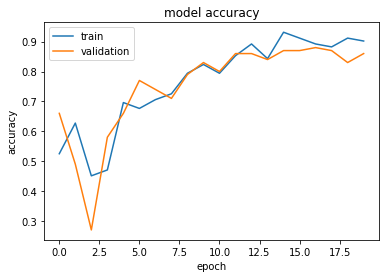

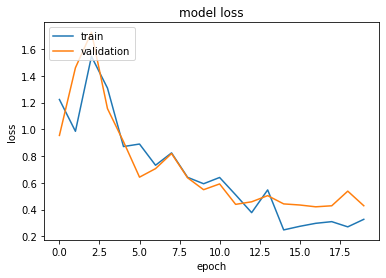

In [28]:
# list all data in history
import matplotlib.pyplot as plt
plot2(historymobilenet_modelG)

# batch_size = 10
num_epochs = 20
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
nb_channel = 3 #RGB

# Transfer learning mobilenet + GRU
# Default learning rate

In [94]:
batch_size = 10
num_epochs = 20
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
nb_channel = 3 #RGB

from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import GRU

model_PreMobile = Sequential()
model_PreMobile.add(TimeDistributed(pretrained_mobilenet,input_shape=(x,y,z,nb_channel)))

model_PreMobile.add(TimeDistributed(BatchNormalization()))
model_PreMobile.add(TimeDistributed(MaxPooling2D((2, 2))))
model_PreMobile.add(TimeDistributed(Flatten()))

model_PreMobile.add(GRU(128))
model_PreMobile.add(Dropout(0.25))

model_PreMobile.add(Dense(128,activation='relu'))
model_PreMobile.add(Dropout(0.25))

model_PreMobile.add(Dense(5, activation='softmax'))

#
train_generatorPreM = generator_2(train_path, train_doc, batch_size,x,y,z)
val_generatorPreM = generator_2(val_path, val_doc, batch_size,x,y,z)
#

optimiser = optimizers.Adam() #write your optimizer
model_PreMobile.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_PreMobile.summary())



C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_81 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_82 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_83 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_84 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16512     
__________

In [97]:
validation_steps,steps_per_epoch,callbacks_list = model_init('modelPreMobGRU_init',num_train_sequences,batch_size,num_val_sequences)
history_PreMobileG = model_PreMobile.fit_generator(train_generatorPreM, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generatorPreM, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Epoch 1/20
67/67 [==============================] - 368s 5s/step - loss: 0.7920 - categorical_accuracy: 0.7612 - val_loss: 0.8463 - val_categorical_accuracy: 0.7100

Epoch 00001: saving model to modelPreMobGRU_init_2020-07-0100_11_07.975845/model-00001-0.79201-0.76119-0.84631-0.71000.h5
Epoch 2/20
67/67 [==============================] - 358s 5s/step - loss: 0.7360 - categorical_accuracy: 0.7512 - val_loss: 1.1070 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to modelPreMobGRU_init_2020-07-0100_11_07.975845/model-00002-0.73600-0.75124-1.10703-0.61000.h5
Epoch 3/20
67/67 [==============================] - 357s 5s/step - loss: 0.6718 - categorical_accuracy: 0.8010 - val_loss: 0.7011 - val_categorical_accuracy: 0.7600

Epoch 00003: saving model to modelPreMobGRU_init_2020-07-0100_11_07.975845/model-00003-0.67179-0.80100-0.70108-0.76000.h5
Epoch 4/20
67/67 [==============================] - 356s 5s/step - loss: 0.8919 - categorical_accuracy: 0.7264 - val_loss: 0.8383 - val_

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


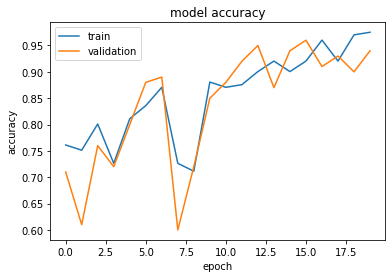

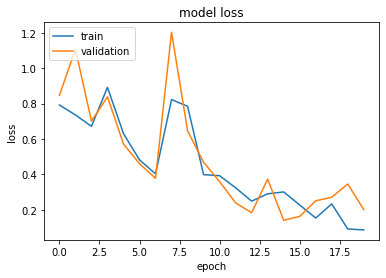

In [98]:
plot2(history_PreMobileG)

# batch_size = 10
num_epochs = 20
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
nb_channel = 3 #RGB

# Transfer learning mobilenet + LSTM
# Default learning rate

In [99]:
batch_size = 10
num_epochs = 20
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
nb_channel = 3 #RGB

from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

model_PreMobile2 = Sequential()
model_PreMobile2.add(TimeDistributed(pretrained_mobilenet,input_shape=(x,y,z,nb_channel)))

model_PreMobile2.add(TimeDistributed(BatchNormalization()))
model_PreMobile2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_PreMobile2.add(TimeDistributed(Flatten()))

model_PreMobile2.add(LSTM(128))
model_PreMobile2.add(Dropout(0.25))

model_PreMobile2.add(Dense(128,activation='relu'))
model_PreMobile2.add(Dropout(0.25))

model_PreMobile2.add(Dense(5, activation='softmax'))

#
train_generatorPreM = generator_2(train_path, train_doc, batch_size,x,y,z)
val_generatorPreM = generator_2(val_path, val_doc, batch_size,x,y,z)
#

optimiser = optimizers.Adam() #write your optimizer
model_PreMobile2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_PreMobile2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_85 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_86 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_87 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_88 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
__________

In [100]:
validation_steps,steps_per_epoch,callbacks_list = model_init('modelPreMobLSTM_init',num_train_sequences,batch_size,num_val_sequences)
history_PreMobileLSTM = model_PreMobile2.fit_generator(train_generatorPreM, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generatorPreM, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/20
Source path = Source path =  C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/train ; batch size = 10
 C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val ; batch size = 10
67/67 [==============================] - 1322s 20s/step - loss: 0.9699 - categorical_accuracy: 0.6249 - val_loss: 0.4274 - val_categorical_accuracy: 0.8100

Epoch 00001: saving model to modelPreMobLSTM_init_2020-07-0102_10_23.903426/model-00001-0.97418-0.62443-0.42742-0.81000.h5
Epoch 2/20
67/67 [==============================] - 363s 5s/step - loss: 0.9579 - categorical_accuracy: 0.6269 - val_loss: 1.2939 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to modelPreMobLSTM_init_2020-07-0102_10_23.903426/model-00002-0.95785-0.62687-1.29391-0.50000.h5
Epoch 3/20
67/67 [==============================] - 363s 5s/step - loss: 0.9263 - categorical_accuracy: 0.7065 - val_loss: 0.8673 - val_categorical_accuracy: 0.7100

Epoch 00003: saving model 

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


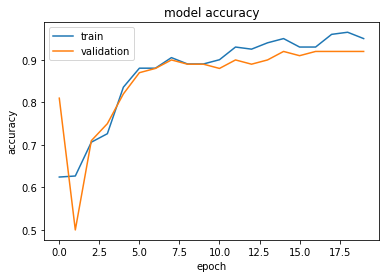

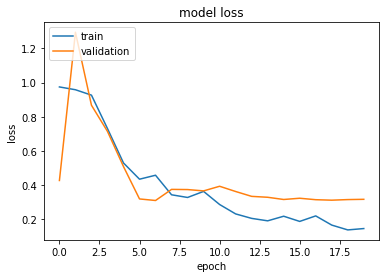

In [101]:
plot2(history_PreMobileLSTM)

# batch_size = 10
num_epochs = 20
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
nb_channel = 3 #RGB

# Conv2D + STacked LSTM (3layers)
# Default learning rate

In [102]:
#Model-- model3_StackLSTM
# conv2D with stacked LSTM - 3 hidden layers

num_epochs = 20
batch_size = 10
x=30
y=120
z=120
print('Batch size', batch_size)
print('# epochs', num_epochs)

input_shape = (x,y,z,3)

model3_StackLSTM = Sequential()
# define CNN model
model3_StackLSTM.add(TimeDistributed(Conv2D(256, (3, 3), input_shape=input_shape, activation='relu')))
model3_StackLSTM.add(TimeDistributed(MaxPooling2D(pool_size = (2, 2))))
model3_StackLSTM.add(TimeDistributed(Flatten()))
# define stacked LSTM model - 3 hidden layers
model3_StackLSTM.add(LSTM(256, return_sequences=True))
model3_StackLSTM.add(LSTM(128, return_sequences=True))
model3_StackLSTM.add(LSTM(64, return_sequences=True))
model3_StackLSTM.add(Flatten())
model3_StackLSTM.add(Dense(5, activation='softmax'))
model3_StackLSTM.build((None,) + input_shape)



optimiser = optimizers.Adam() #write your optimizer
model3_StackLSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3_StackLSTM.summary())


#************************
train_generatorSL = generator_2(train_path, train_doc, batch_size,x,y,z)
val_generatorSL = generator_2(val_path, val_doc, batch_size,x,y,z)

#*************************

    
validation_steps,steps_per_epoch,callbacks_list = model_init('model3_StackLSTM_init',num_train_sequences,batch_size,num_val_sequences)
history_3StackLSTM = model3_StackLSTM.fit_generator(train_generatorSL, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generatorSL, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Batch size 10
# epochs 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_89 (TimeDis (None, 30, 118, 118, 256) 7168      
_________________________________________________________________
time_distributed_90 (TimeDis (None, 30, 59, 59, 256)   0         
_________________________________________________________________
time_distributed_91 (TimeDis (None, 30, 891136)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 256)           912786432 
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 128)           197120    
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
flatten_19 (Flatten)         (None, 1920)         

KeyboardInterrupt: 

In [104]:
# plot2(history_3StackLSTM)

In [1]:
# test example
# Prediction
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import tensorflow as tf
 
from keras.models import load_model
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from skimage import transform
# 1-Right swipe 2-Stop 
# 3-Thumbs Down 4-Thumbs up 
# 5-Left Swipe

Using TensorFlow backend.


(None, 30, 120, 120, 3)


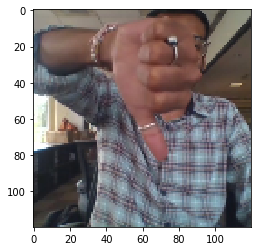

(1, 30, 120, 120, 3)
[3]
Shape (1,)
[[0.01778853 0.00258684 0.07901753 0.7312422  0.16936487]]


In [22]:
loaded_model = load_model("C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/model4g1_init_2020-06-3016_23_21.921567/model-00011-1.03819-0.57971-1.18330-0.55000.h5", compile = False)
print(loaded_model.layers[0].input_shape) #(None, 30, 120, 120, 16)

image_path="C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val/WIN_20180907_16_02_09_Pro_Thumbs Down_new/WIN_20180907_16_02_09_Pro_00029.png"
img = image.load_img(image_path, target_size=(120, 120))
plt.imshow(img)
plt.show()
np_image = np.array(img).astype('float32')/255
np_image = transform.resize(np_image, (30,120,120, 3))
np_image = np.expand_dims(np_image, axis=0)
print(np_image.shape)
result=loaded_model.predict_classes(np_image)
print(result)
print('Shape',result.shape)
print(loaded_model.predict_proba(np_image))

(None, 30, 120, 120, 3)


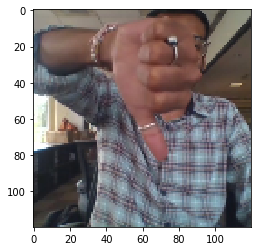

(1, 30, 120, 120, 3)
[2]


In [113]:
from keras.applications import mobilenet
from keras.preprocessing.image import load_img
from keras.models import load_model
loaded_model = load_model('C:\\Users\\N V S\\Desktop\\Course5_ModuleGestureRecog\\modelPreMobLSTM_init_2020-07-0102_10_23.903426\\model-00017-0.22041-0.93035-0.31511-0.92000.h5')
print(loaded_model.layers[0].input_shape) #(None, 30, 120, 120, 16)

image_path="C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Project_data/val/WIN_20180907_16_02_09_Pro_Thumbs Down_new/WIN_20180907_16_02_09_Pro_00029.png"
img = load_img(image_path, target_size=(120, 120))
plt.imshow(img)
plt.show()
np_image = np.array(img).astype('float32')/255
np_image = transform.resize(np_image, (30,120,120, 3))
np_image = np.expand_dims(np_image, axis=0)
print(np_image.shape)
result=loaded_model.predict_classes(np_image)
print(result)
# print(loaded_model.predict_proba(np_image))

(None, 30, 120, 120, 3)


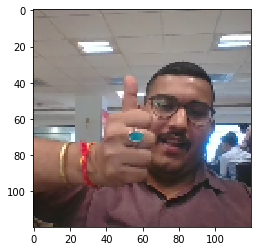

(1, 30, 120, 120, 3)
(1,)
[[0.18372256 0.16829725 0.61452466 0.01371877 0.01973677]]


In [25]:
loaded_model = load_model('C:\\Users\\N V S\\Desktop\\Course5_ModuleGestureRecog\\modelPreMobLSTM_init_2020-07-0102_10_23.903426\\model-00017-0.22041-0.93035-0.31511-0.92000.h5')
print(loaded_model.layers[0].input_shape) #(None, 30, 120, 120, 16)

image_path="C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Test_set/WIN_20180907_15_38_42_Pro_00039.png"
img = load_img(image_path, target_size=(120, 120))
plt.imshow(img)
plt.show()
np_image = np.array(img).astype('float32')/255
np_image = transform.resize(np_image, (30,120,120, 3))
np_image = np.expand_dims(np_image, axis=0)
print(np_image.shape)
result=loaded_model.predict_classes(np_image)
print(result.shape)
print(loaded_model.predict_proba(np_image))

(None, 30, 120, 120, 3)


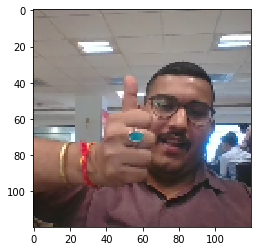

(1, 30, 120, 120, 3)
[3]
[[0.28611207 0.0055556  0.00692049 0.43528637 0.2661255 ]]


In [31]:
# test example
# Prediction
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import tensorflow as tf
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from skimage import transform
# 1-Right swipe 2-Stop 
# 3-Thumbs Down 4-Thumbs up 
# 5-Left Swipe

loaded_model = load_model('C:\\Users\\N V S\\Desktop\\Course5_ModuleGestureRecog\\GestureRecognition_GroupCaseStudy\\model-00019-0.06637-0.98010-0.22752-0.93000.h5')
print(loaded_model.layers[0].input_shape) #(None, 30, 120, 120, 16)

image_path="C:/Users/N V S/Desktop/Course5_ModuleGestureRecog/Project_data/Test_set/WIN_20180907_15_38_42_Pro_00039.png"
img = load_img(image_path, target_size=(120, 120))
plt.imshow(img)
plt.show()
np_image = np.array(img).astype('float32')/255
np_image = transform.resize(np_image, (30,120,120, 3))
np_image = np.expand_dims(np_image, axis=0)
print(np_image.shape)
result=loaded_model.predict_classes(np_image)
print(result)
print(loaded_model.predict_proba(np_image))